WARNING: DO NOT (YET) CITE OR USE! THIS IS STILL A DRAFT.

# INTRODUCTION TO LEGAL NETWORK ANALYSIS

Edition 1 (version 1) (2022)

# AUTHORS
- Gustavo Arosemena
- Gijs van Dijck
- Roland Moerland

# CONTRIBUTORS
- Maxine Hanrieder

# LICENSE

This textbook is released under a CC BY license. This license lets you distribute, remix, adapt, and build upon our work, even commercially, as long as you credit us for the original creation. 

![license](images/cclicense.png)


# Chapters
[Welcome](#Welcome)

[1. Network Analysis: An Introduction](#1_Network_Analysis:_An_Introduction)

[2. Network Properties](#2_Network_Properties)

[3. Network Centrality](#3_Network_Centrality)

[4. Community Detection](#4_Community_Detection)

[5. Data Collection and Data Preparation](#5_Data_Collection_and_Data_Preparation)

[6. Software](#6_Software)

[Bibliography](#Bibliography)

# Appendices
Text similarity network



# Welcome

Welcome to this introduction in Legal Network Analysis. The aim of this introduction is to provide you with a theoretical and practical understanding of what network analysis is, what it can be used for in the context of legal research, and how it can be applied. 

The theory will be discussed and illustrated by means of practical examples and sometimes exercises. We try to accommodate readers with different levels of proficiency in coding:
- If you have no coding (in Python) experience, you can read the PDF (or the notebook) and simply skip the code that is displayed.
- If you have experience with running code (e.g. in Jupyter Notebook or VScode), you can execute the code. We have entered the code for you, which means you only have to run the code.
- If you have experience with Python (and NetworkX), you may download the Jupyter Notebook file and alter the code.

The textbook aims to introduce network analysis to legal scholars in a comprehensive and practical way. If you are interested in more background information regarding networks, their analysis and the graph theory underlying it, please feel free to consult the books listed below. We selected publications that are accessible when you are not yet versed in network analysis.

Networks:
-	Newman, M. (2018). Networks. London: Oxford University Press.

(Social) Network analysis:
-	John, S. (2017). Social Network Analysis. Sage.
-	Robins, G. (2015). Doing social network research. Routledge.
-	Scott, J. and Carrington, P.J. (2011). The SAGE handbook of Social Network Analysis. Sage
-	Tsvetovat, M., & Kouznetsov, A. (2011). Social Network Analysis for Startups: Finding connections on the social web. O'Reilly.

Graph theory:
-	Wallis, W. D. (2007). A beginner's guide to graph theory. Springer.
-	Rahman, M. S. (2017). Basic graph theory. Springer. 
-	Steen, M. R. van. (2010). Graph theory and complex networks: An introduction. Maarten van Steen.


We, the authors, hope you will enjoy our introduction to Legal Network Analysis. We are always open to feedback, suggestions, and help. You can reach us at law-techlab@maastrichtuniversity.nl.

## Run me first!

If you want to run the code in this textbook (notebook), you will need to run the following cells. Please make sure that you have all the required dependencies.

You can find the main dependencies in the "dependencies.yml" file in this repository. If you download it you can run  <code>
conda env create --name networkanalysis --f dependencies.yml
</code> 
from your terminal to 


In [1]:
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# Premade graphs
g_kite = nx.krackhardt_kite_graph()
g_florentine = nx.florentine_families_graph()
g_karate = nx.karate_club_graph()

# Other example graphs available on the "data" folder of this repo
df_consprot = pd.read_csv('data/PROT_edges.csv', sep = ",")
g_consprot = nx.from_pandas_edgelist(df_consprot, "Source", "Target", create_using=nx.DiGraph) #setting up the directed graph
# subgraph of consprot
node_degree_dict=nx.degree(g_consprot)
g_consprot2=nx.subgraph(g_consprot,[x for x in g_consprot.nodes() if node_degree_dict[x]>=25])

df_trains = pd.read_csv('data/trainnetworknl.csv', names=['origin', 'destination'])
g_trains = nx.Graph()
[g_trains.add_node(node) for node in df_trains.origin]
[g_trains.add_edge(node,edge) for node, edge in zip(df_trains.origin, df_trains.destination)]

df_reviews = pd.read_csv("data/ignatieff_reviews.csv")

df_docs = pd.read_csv('data/docsimilarity.csv', index_col="Unnamed: 0")

g_docs = nx.Graph()
[g_docs.add_node(node) for node in df_docs.source]
[g_docs.add_edge(node,edge, weight = weight) for node, edge, weight in zip(df_docs.source, df_docs.target, df_docs.weight)]

df_furniture = pd.read_csv('data/furniturewebsites.csv')
df_furniture['links'] = df_furniture.links.str.split(', ')
df_furniture = df_furniture.explode('links')
g_furniture = nx.DiGraph()
g_furniture.add_nodes_from(df_furniture.webpage)
g_furniture.add_edges_from(zip(df_furniture.webpage, df_furniture.links))

df_treaties = pd.read_csv('data/mytreaties.csv')
g_treaties = nx.Graph()
[g_treaties.add_node(node, bipartite=0) for node in df_treaties.State if node != np.nan]
[g_treaties.add_node(node, bipartite=1) for node in df_treaties.treaty if node != np.nan]
[g_treaties.add_edge(state, treaty) for state, treaty in zip(df_treaties.State, df_treaties.Affiliation) if treaty != np.nan];

df_history = pd.read_csv("data/legal_history.csv", sep=";")
df_history.set_index("Unnamed: 0", inplace=True)
g_history = nx.from_pandas_adjacency(df_history)
g_history = nx.to_directed(g_history)

# Styling and reproducibility
sns.set_style('whitegrid')
pd.set_option("display.precision", 3)
np.random.seed(123)

# 1_Network_Analysis:_An_Introduction

## 1.1 What Is Network Analysis?

Network analysis concerns the measurement and mapping of relationships between entities. Entities can consist of individuals, groups of persons, court decisions, molecules, or any other subject or object.

Applications of network analysis can be found in a variety of academic disciplines, including natural sciences, medical science, social sciences, humanities, and law. For instance, one can map communication of a group of social media users (Figure 1). By mapping who communicates with whom, clusters may emerge of groups of users who more frequently communicate with entities within their cluster than with users outside of their cluster. It can also become apparent who is more central (popular) within the various clusters or in the network as a whole. Furthermore, one may identify so-called 'brokers', individuals who connect clusters of users and consequently form the glue that holds the network together. 

Figure 1: Example of social media network 

<img src="images/ch1/exampleofsocialmedia.png" alt="drawing" width="400"/>

(Source: Wikipedia)

Network analysis relies on the assumption that the structural relationships between entities (e.g. persons) provide relevant information that the attributes of those entities alone cannot offer. The extent to which users are communicative, possess electronic devices, or are member of social platforms does not provide any or sufficient insight into how the users relate to one another. Network analysis reveals those relationships between entities, hence generating relevant information that the features such as communication skills or platform membership alone do not offer.

## 1.2 Origins of Network Analysis

Network analysis comes from graph theory, for which the foundations were laid by Leonhard Euler in 1736, who proved that the problem of 'The Seven Bridges of Königsberg' (currently Kaliningrad, Russia).

<img src="images/ch1/konigsberg.png" alt="drawing" width="400"/>

(Source: Google Maps)


Königsberg was divided by the Pregel River, and it had two islands that were connected to each other and to the city's mainland by seven bridges. The mathematical problem that Euler solved was to design a walk through that would include the two parts of the mainland as well as the two islands where the person would cross each of the bridges exactly once (Figure 3).

<img src="images/ch1/konigsberg_bridges.png" alt="drawing" width="150"/>

 ![image2](images\ch1\konisberg_bridges_2.png)
 
 ![image2](images\ch1\konisberg_bridges_3.png)

Source: Wikipedia

Euler demonstrated that the 'Seven Bridges of Königsberg' problem does not have a solution, and that a walk through town while crossing every bridge exactly once, depends on the number areas (mainland + islands) and on the number of bridges. Euler proved that the desired walk can only take place if the areas are connected and include exactly zero or two areas with an odd number of bridges. Königsberg had four areas and seven bridges at the time. Three areas had three bridges and one area had five bridges. As a result, the rule is violated, as there are four areas with an odd number of bridges.

Seven bridges were bombed in World War II. Five bridges were rebuilt. Interestingly, in terms of graph theory, a Eulerian path became possible after the rebuilt (1->2->3->4->5, Figure 4). Now, two areas (B + C) have two bridges, whereas the other two areas (A + D) have three bridges (edges). This means that there are exactly two nodes with an uneven number of bridges.

![images](images/ch1/konisberg_bridges_4.png)

Source: Wikipedia

## 1.3 What Questions Can Be Answered with Legal Network Analysis?

Network analysis focuses on relational patterns and structures that arise from interaction between the entities (called 'nodes). This approach allows analyzing a great variety of networks, ranging from online cyber communities and corporate relations networks to social movements, political affiliations, sports clubs and scholarly communities. Although there are many different categories of networks, they can more generally be grouped under the headings of technological networks (distribution, transportation, internet) information networks (citation, discourse), and social networks (friends, professional) (Newman 2018).

Network analysis can also be a relevant approach for legal scholars and criminologists. It allows legal scholars to, for instance, analyse legal citation networks. For criminologists, the network analytical approach can be relevant when conducting research on organized crime syndicates and how they are organized.

Network analysis in the legal domain is often applied to court decisions or legislation. In this regard, examples of questions are:
- What are the most important precedents? 
  - Example publication: M. Derlen and J. Lindholm (2014). Goodbye van Gend en Loos, Hello Bosman? Using Network Analysis to Measure the Importance of Individual CJEU Judgments. European Law Journal, 20(5), 667-87. https://doi.org/10.1111/eulj.12077
- How does case importance change over time?
  - Example publication: M. Derlen and J. Lindholm, ‘Is it Good Law? Network Analysis and the CJEU’s Internal Market Jurisprudence’ (2017) 20 Journal of International Economic Law 257-77. https://doi.org/10.1093/jiel/jgx011
- Have certain legal topics or legal concepts gained or lost importance over time?
  -	Example publication: J. Fowler and S. Leon, ‘The Authority of Supreme Court Precedent’ (2008) 30 Social Networks 16-39. https://doi.org/10.1016/j.socnet.2007.05.001
- Which clusters of decisions can be distinguished? 
  - Example publication: Y. Lupu and E. Voeten (2011). Precedent in International Courts: A Network Analysis of Case Citations by the European Court of Human Rights. British Journal of Political Science, 42, 413-49. https://doi.org/10.1017/S0007123411000433

Studies that do not apply network analysis to court decisions or legislation concern:
- Patent studies, for instance whether a certain inventor (e.g. Bill Gates) has invented in a wider variety of areas than another inventor (e.g. Mark Zuckerberg).
  - Example publication: R. Whalen, A. Lungeanu, L. DeChurch, and N. Contractor (2020). Patent Similarity Data and Innovation Metrics, Journal of Empirical Legal Studies 17(3), 615-639. https://doi.org/10.1111/jels.12261
- How can network analysis by used to provide relevant,
timely and actionable intelligence for criminal networks?
  - Example publication: P. Seidler & R. Adderley (2013). Criminal Network Analysis inside Law Enforcement Agencies: A Data-Mining System Approach under the National Intelligence Model. International Journal of Police Science & Management, 15(4), 323–337. https://doi.org/10.1350/ijps.2013.15.4.321.
- How do law firms partners exercise control over others in the firm?
  - Example publication: E. Lazega, D. Krackhardt (2020). Spreading and Shifting Costs of Lateral Control Among Peers: A Structural Analysis at the Individual Level. Quality & Quantity 34, 153–175. https://doi.org/10.1023/A:1004759418226.

## 1.4 Key Concepts of Network Analysis

### A) Nodes & Edges
Networks consist of two key concepts: nodes and edges. Nodes are the smallest unit in a network. As indicated above, nodes can consist of various types of entities: individuals, court cases, documents, words, etc. Edges are the links between two nodes. In graph representation, edges are presented with a line (in undirected graphs) or by an arrow (in directed graphs) that points from one node to another.

Note that in the literature nodes can also be called vertices (singular: vertex) and that edges are referred to as lines, arcs (in directed networks) or edges (in undirected networks).

### B) Undirected Graphs versus Directed Graphs
Graphs can be directed or undirected. Directed can be described as a non-reciprocal relationship (Figure 5). For instance, A sends a message to B, C admires D, or E cites F.

<img src="images/ch1/directed_graph.png" alt="drawing" width="150"/>

Undirected graphs consist of reciprocal relationships (Figure 6). A and B are friends (or: A is friends with B, B is friends with A), or A shakes hands with B. It is not common (although perhaps possible) that a friendship goes from A to B but not from B to A, making it reciprocal.

<img src="images/ch1/undirected_graph.png" alt="drawing" width="150"/>

### C) Network Visualization

We can make observations and inferences by looking at a network. However, when we later ask ourselves questions such as "which are the most central nodes in the network?", we should not lose track of the fact that networks can be drawn in different ways without changing their properties. Some visualizations can even be misleading. The three plots below represent the exact same network (image from Wallis 2007, page 7). If one asks "which node is the most central one?" in relation to this particular network, the drawing on the left probably provides us with the best visualisation to provide the correct answer.

![image](images/ch1/equivalent_viz.png)

### D) Bipartite Graphs

Networks typically deal with relations between a single class of elements. With single class of elements, we mean that the nodes are of a similar type, belong to the same class. For example, we may be interested in citations between cases, friendship between persons, and so forth. In these instances, the classes of the elements are the same: cases, persons, etc. Yet sometimes it is interesting to consider the relationship between two different types of elements. Imagine we want to research what happens when states ratify certain treaties. This must be a bipartite network because we have a relationship between two types of nodes: states and treaties.

Below you can see an example of how a bipartite graph might look.

Figure 8: Bipartite network


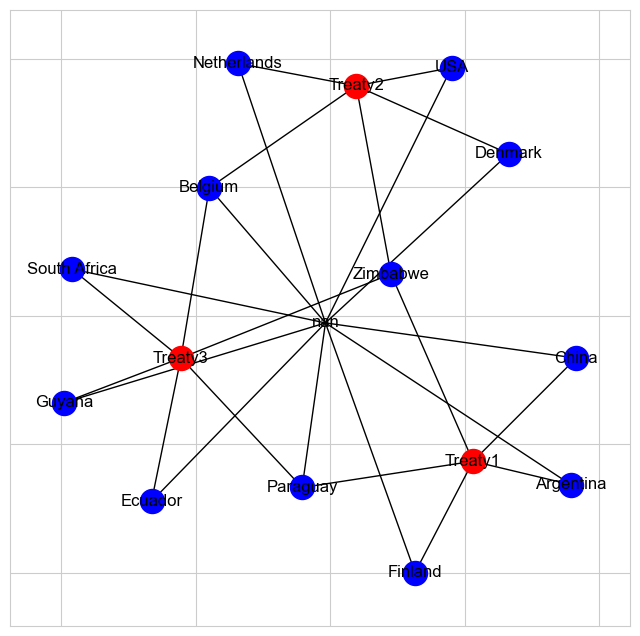

In [104]:
pos = nx.spring_layout(g_treaties)
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist=['Argentina', 'Belgium', 'China', 'Denmark', 'Ecuador', 'Finland', 'Guyana', 'Netherlands', 'Paraguay', 'South Africa', 'USA', 'Zimbabwe'], node_color='blue')
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist=['Treaty1', 'Treaty2', 'Treaty3'], node_color='red')
nx.draw_networkx_edges(g_treaties, pos=pos)
nx.draw_networkx_labels(g_treaties, pos=pos);

### E) Graphs versus Networks
Graphs and networks are common terms in the area of network analysis. Strictly speaking, the terms point to different aspects. Graphs consist of a set of nodes and a set of edges between pairs of nodes. A networks consists of a graph plus additional information regarding the nodes. These attributes can include a variety of information, such as, in case the nodes consist of documents, the year in which the document was published, the language of the documents, the creator or author, etc.

### F) Directed Acyclic Graph (DAG)
Graphs that deal with legislation are often (but not necessarily) DAGs. They are directed, because the edges go from one node to another. They are acyclic, because edges commonly do not go, for instance, from A to B to C to A. 

References in case law also serve as a good illustration. A citation network that consists of a number of court decisions that refer to one another is directed: the citation goes from one court decision to another. The network is also acyclic. This is because court decisions commonly only cite cases from the past, not from the future. Would a network be cyclic, it would be possible that a 2016 decision cites a court decision from the year 2020. Exceptions can, however, occur. For example, cases that are published on the same date can reference each other. In an instance of A cites B and B cites A, a loop is created, which makes the graph cyclical.

### G) Power Law Distribution
Citation networks frequently have a Power Law distribution. This means that the frequency distributions are highly skewed: few nodes have a relatively high number of citations, whereas most nodes have a low number of citations. We illustrate this by means of a network of CJEU (Court of Justice of the European Union) case law, where the source nodes consist of cases that are labeled as 'consumer protection'. With source nodes, we mean the cases that were searched and for which the citations in those cases were harvested. In this network, the cases are the nodes and the references in and to the cases the edges. The network consists of 1,614 nodes (cases) and 2,662 edges (references).

Focusing on the number of incoming citations, we plot the distribution of incoming citations among the cases. We do so by means of a histogram, where the horizontal axis shows the number of incoming citations and the vertical axis the number of cases. The results reveal that a relatively small number of cases have a relatively high number of incoming citations, whereas there are a lot of cases that are hardly ever, if at all, cited. The differences are substantial: most cases are hardly cited, whereas few cases are cited over 10 times.

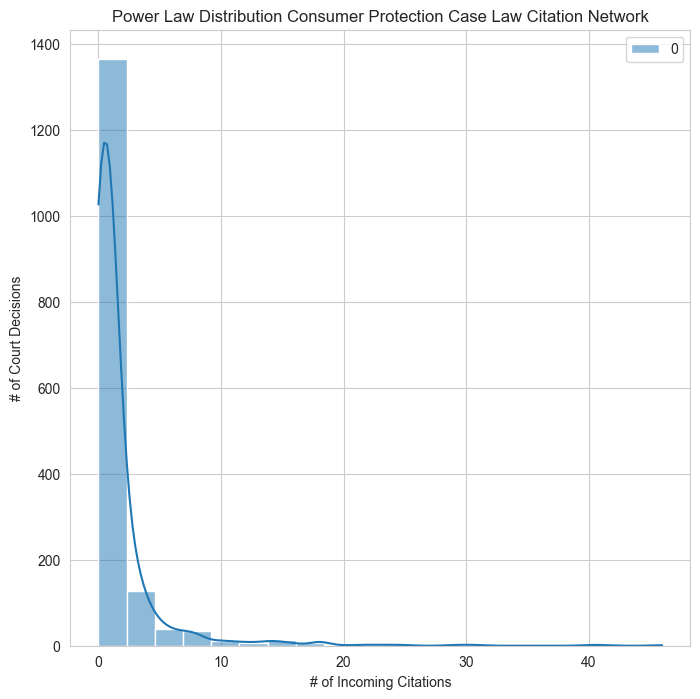

In [105]:
plt.title("Power Law Distribution Consumer Protection Case Law Citation Network")
plt.xlabel("# of Incoming Citations") #add label
plt.ylabel("# of Court Decisions") #add label
sns.histplot(dict(g_consprot.in_degree).values(), stat="count", bins=20, kde=True); #plot


One of the effects of a Power Law distribution is that it is coupled with preferential attachment. This is also called the 'rich get richer' effect: the nodes with many edges are likely to receive more edges (eg citations) in the future for the mere fact that they already had many edges. Do note that "law" in power law distributions refers to something akin to a "law of nature". It does not have anything to do with the law as in norms or rules.

### H) Node Degree and Node Centrality
Network analysis is a method that can capture how central a node is in a network. This centrality can be an indicator for, for instance, the popularity or relevance of a node in a network.	

Various measures exist to measure the centrality of a node. Some basic measures in legal network analysis are:
- Degree. The total number of edges connected to a node. Degree Centrality normalizes (standardizes) the degree score, resulting in a score between 0 and 1 (by dividing the degree by the number of nodes minus 1 (n-1)).
- Out-Degree. In directed networks, it is possible to calculate the number of edges pointing out of a node. Out-degree centrality is the normalized score of out-degree.
- In-Degree. Directed networks also allow calculating the number of edges pointing to a node. In-degree centrality is the normalized score of in-degree.
- Relative in-degree centrality. This metric provides more weight to more recent nodes. Older nodes are more likely to have incoming edges than more recent nodes. For instance, a court decision from 1998 is more likely to receive many citations than one from 2021 (all other things equal), simply because it has been around longer and consequently has had more opportunities to receive citations. Relative in-degree centrality corrects for this by giving more weight to more recent nodes.
- Betweenness Centrality. This score expresses the relative control that a node exerts over the flow of information within a network, i.e. number of geodesic paths that run through the node, with a geodestic path being the shortest path between two nodes. A simpler way of understanding betweenness centrality is by using the metaphor of glue: what is the glue that keeps the network together? Nodes with a high betweenness centrality score are more of a glue than nodes with a low score - without these nodes, the network is likely to fall apart or to reach another node in a 'quick' way. Another way of describing nodes with a high betweenness centrality is to call them 'brokers' that connect nodes.

We will discuss different metrics in more detail in subsequent chapters. For now, it is sufficient to have a general understanding of what the various degree and centrality scores measure and how they differ from one another.

#### Exercise
To test whether you properly understood some of the centrality and degree measures, we turn to the so-called Krackhard Kite Graph (Figure 7).
</br>
</br>
Figure 7: Krackhard Kite Graph
</br>
<img src="images/ch1/kite.png" alt="drawing" width="250"/>


Answer the following questions and write down the answers for yourself. You will see the answers below.  

1.	Is this a directed or undirected graph?  
2.	Which node(s) has (have) the highest degree centrality? (incoming and outgoing links)  
3.	Which node(s) has (have) the highest in-degree centrality? (incoming links)  
4.	Which node(s) has (have) the highest betweenness centrality? (Or: What is the glue that keeps the network together / Which node fulfills the broker function the best?)  

#### Answers

1.	Is this a directed or undirected graph? 

In a directed graph, you would expect the edges to have arrows, indicating from and to which node the edge goes. Our graph does not have arrows, hence we can assume it is an undirected graph.

2.	Which node(s) has (have) the highest degree centrality (i.e. normalized score of incoming and outgoing edges combined)? 

A count of the number of edges for each node makes it clear that Node 3 has the highest degree (degree = 6). We can calculate the normalized score by deviding the degree score by the number of nodes minus 1, which results in (6 / (9-1) =) 0.75. However, if we know which node has the highest degree score, it will also be the node with the highest degree centrality.

3.	Which node(s) has (have) the highest in-degree (i.e. incoming edges)? 

This is a trick question. Calculating he in-degree score is only possible in case of a directed network. Considering we have an undirected, nodes do not have an in-degree value (or an out-degree value, for that matter).

4.	Which node(s) has (have) the highest betweenness centrality? (Or: What is the glue that keeps the network together / Which node fulfills the broker function the best?) 

Node 7 has the shortest path to all other nodes in the network. This node therefore has the highest betweenness centrality.

### I) Community Detection

Network analysis allows for the detection of communities. Some also use the terms 'cliques' or 'clusters', although these terms have slightly different meanings for some. The idea behind community detection is to group together nodes that have edges among one another. Nodes are more likely to be connected if they are members of the same community, and less likely to be connected if they are part of different communities. Nodes that belong to the same community are likely to share common attributes or functions, and they often possess different properties than the larger network (Figure 8).

<img src="images/ch1/community_detection.png" alt="drawing" width="250"/>

Various algorithms exist to detect communities. One that is frequently used, is modularity maximization. Modularity maximazation concerns the fraction of edges within a group minus the fraction of edges that could be expected if the graph was a random graph. Modularity maximazation can be calculated, resulting in a Q score. The higher value of Q (min = -1, max = 1), the stronger the community structure in the network is. Q = 0 means a community structure not better than random, whereas 0.3 < Q < 0.7, is associated with significant community structure.

# 2_Network_Properties

This section will provide more detail about the structure of networks.

## 2.1 Paths, Shortest Paths, and Distance between Nodes

For any node of the network, it is possible to calculate the path it has to other nodes (if such a path exists) and its distance. A path is a series of steps getting from node A to node B. The distance is the number of steps, or the number of steps weighted by any relevant weight metric. 

Some complications deserve mention here:

* When nodes are disconnected
* Fully connected networks
* Shortest path
* Weighted paths
* Random paths
* Eccentricity and network diameter

Let us discuss the complications in more detail.


### A) When nodes are disconnected

It is not guaranteed that there will be a path between two nodes. It is possible that two sets of nodes are simply not connected. In this case there is no path between nodes A, B, or C, and nodes D or E, as we can see from this example:

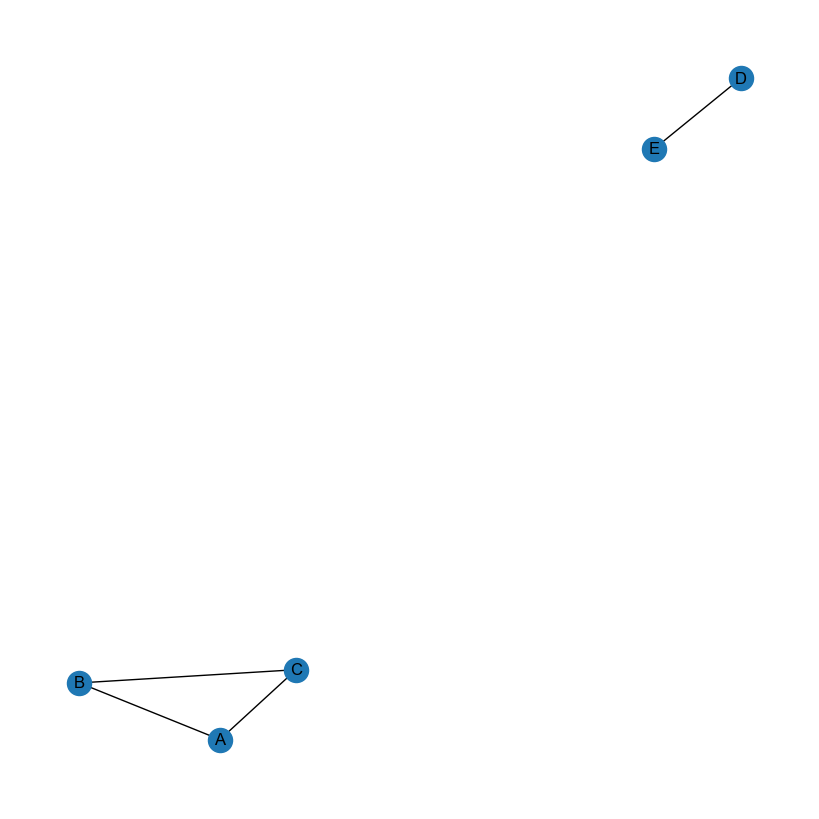

In [106]:
g_disconnected = nx.Graph()
g_disconnected.add_nodes_from(['A','B','C','D','E'])
g_disconnected.add_edges_from([('A','B'),('B','C'), ('C','A'),('D','E')])
pos = nx.spring_layout(g_disconnected, seed=123)
nx.draw(g_disconnected, pos=pos)
nx.draw_networkx_labels(g_disconnected, pos=pos);

When there is no path between two nodes, it makes sense to say that there is infinite distance between them. It would be getting things the wrong way round to state that there is a distance of 0. A distance of 0 would suggest that the nodes are right on top of each other, when the reality is that they are unreachable.

### B) Fully connected networks

A network is fully connected if every node is connected to every other node. To see how this will look consider these graphs from Wolfram (https://mathworld.wolfram.com/CompleteGraph.html)

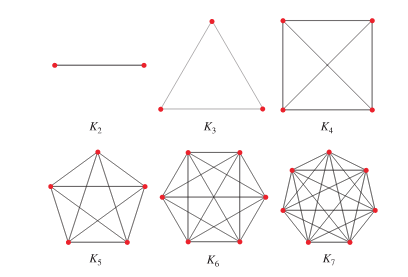

Note that for such networks it would be pointless to try to distinguish between nodes using measures like centrality or community, unless the edges have differing weights.

### C) Shortest paths

The shortest path is, quite simply, the path that will reach a node in the smallest number of steps. There can be more than one "shortest path" (but all the shortest paths will have the same smallest number of steps). For example, if we look at the kite graph, there are two shortest paths from 7 to 3, one going through 6, and another going through 5. There are longer paths too, for example, 7 -> 5 -> 2 -> 3. These may not be immediately relevant, but might be interesting possible random paths, between 7 and 3.

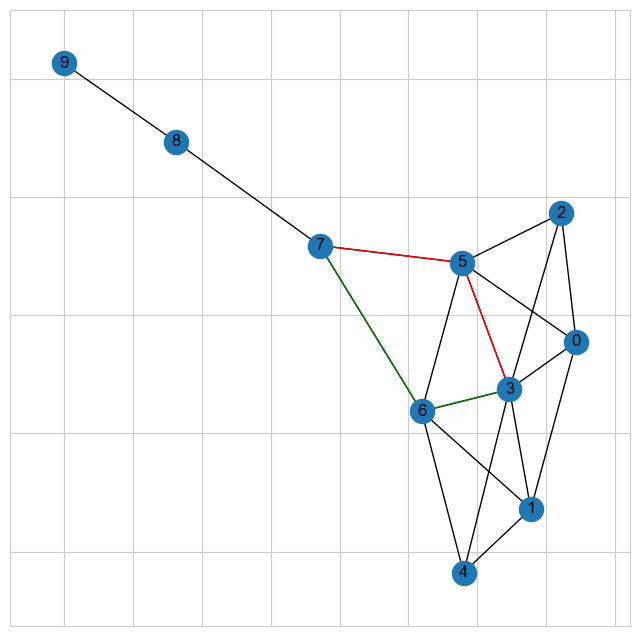

In [107]:
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos)
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_edges(g_kite, edgelist=[(7,5),(5,3)], edge_color="red", pos=pos)
nx.draw_networkx_edges(g_kite, edgelist=[(7,6),(6,3)], edge_color="green", pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

Shortest paths are useful for many purposes. They are key ingredients in many algorithms for identifying node centrality.

While shortest paths can be easy to "see" in small graphs like this one, this will not be possible in more complex graphs. Finding the shortest path will then be a non-trivial problem. This process is automated by network analysis libraries and programs. 

For the unweighted graphs that we are using, a shortest path counts discrete "steps" between nodes. This implies that all the nodes are a unit distance away. However, it is also possible to have weighted paths, as we will see in a bit. 

### D) Random paths

The length of the shortest path will be a definite number. However, there may be an arbitrary number of non-shortest paths wandering through the nodes. A single arbitrary path will not be of much interest (why this one?, why not another one?), but if we allow movement randomly from node to node, these random paths - random walks - can become of interest. We may be interested not only in the shortest path between A and B, but in the mean path distance between A and B, taking into account routes that go more or less directly from A to B, as well as those that make longer detours. By measuring a number of random walks for a number of nodes in the network, it will often become clear that some nodes are more likely to be "passed through" than other nodes, which suggests these nodes are more central and perhaps therefore more relevant or interesting.

NetworkX does not have a random path function built in. However one can make one with the neighbors attribute of the Graph object. The steps are more or less like this:

1. Select a number of steps for the walk. In this case four steps. Do all the steps below until you hit four steps.
2. Select a particular node to start with, for example node 7.
3. Find all the neighbors of node 7 (in this case, 5, 6, 8).
4. Randomly choose one of these nodes to go to. Say choose node 5.
5. Update the value of your start position to the chosen node, in this case 5.
6. Record that you have made one step (3 to go).
7. If you have made less than four steps, go back to step 2. If you have made four steps, stop.

These steps can be implemented in code with some effort.

In [108]:
n = 0
start = 7
history = [start]
while n < 4:
  my_neighbors = list(g_kite.neighbors(start))
  move_to_node = np.random.choice(my_neighbors)
  history.append(move_to_node)
  start = move_to_node
  n += 1

print(history)

[7, 8, 7, 8, 7]


### E) Weighted edges


An edge can show that there is a relationship between nodes A and B. The nature of that relationship can be many things, such as there being a train between A and B, or case A cites case B. In these instances the connection is binary: there either is a connection or there is not.

There are a range of cases where one wants to record the strength of a connection and not just its presence. For example, one might want to record, not only that there is train path from A to B, but also how long that path is in terms of kilometers. We might want to score not only that case A cites case B, but also how many times case B is cited by case A. We can add this attribute to the edge by giving weights to edges. For instance, if case A cites case B four times, the edge weight becomes four.

Weighted networks can be represented visually in an intuitive way by using different colors or line styles for their edges. Below is a network using a document similarity matrix. This matrix records how close two documents are in light of the tokens they share (Jaccard distance) and scores them with 1 if they are identical, and 0 if they are completely different. It is made of Amazon reviews of the book "The Ordinary Virtues" by Michael Ignatieff, which you can see below. 

In [109]:
df_reviews

,Reviewer,Stars,Review
0,Tom,5,A really interesting perspective on the world'...
1,Merrie,5,This is a remarkable book with observations th...
2,Tatler,4,"Perceptive, well-written by qualified analyst...."
3,Nissim,5,The book is very important because it exposes ...
4,Regina,5,Very good
5,Nir,5,"great book, fascinating, lucidly-presented arg..."
6,David,4,This is a moving and humane reflection on mora...
7,Richard,1,The author sincerely believes that if we prole...
8,Tapas,3,It is a book about the modern globalized world...


In the process of comparing the distance between each document, this dataframe is turned into a matrix, and that can be used to build a network. Please see Appendix 1: "Text Similarity Networks" for more details of how this can be done. Here is one way to plot that network:

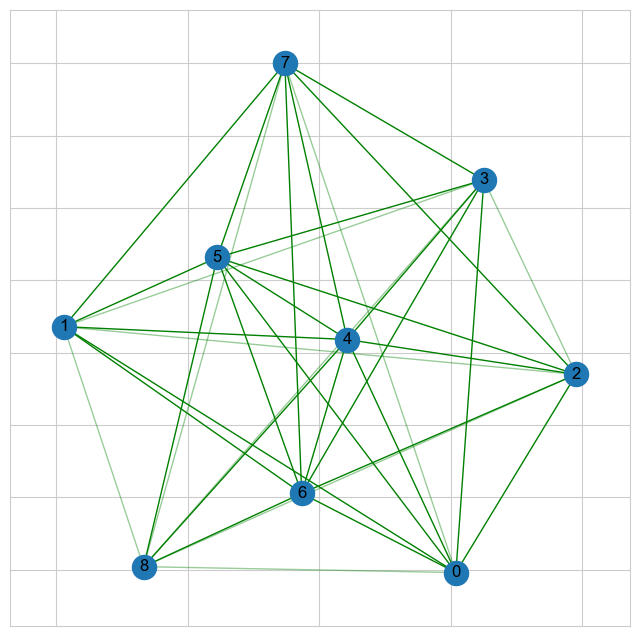

In [110]:
pos = nx.spring_layout(g_docs, seed=123)
nx.draw_networkx_nodes(g_docs, pos)
lowweight = [e for e in g_docs.edges if g_docs.edges[e]['weight'] < 0.3]
highweight = [e for e in g_docs.edges if g_docs.edges[e]['weight'] > 0.3]
nx.draw_networkx_edges(g_docs, edgelist=highweight, pos=pos, edge_color='green')
nx.draw_networkx_edges(g_docs, edgelist=lowweight, alpha=0.4, pos=pos, edge_color='green')
nx.draw_networkx_labels(g_docs, pos=pos);

For our purposes, what is to note is that if you graph the network without consideration of weight, it gives you a fully connected network, which is a nice geometrical figure, but not very informative. Every document was compared to every other document, so every node is on step ("one degree") of separation from every other and so every node has the exact same number of neighbors.

A plot can reveal how uninformative this is:

<BarContainer object of 9 artists>

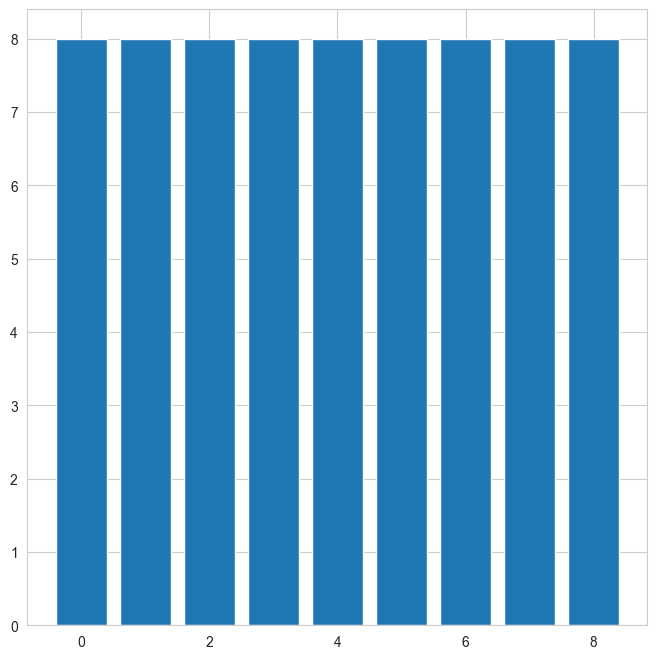

In [111]:
plt.bar(x = list(dict(g_docs.degree).keys()), height = list(dict(g_docs.degree).values()))

It is a bit hard to see, but note that this is a fully connected or complete graph. NetworkX can reveal this to us by simply passing the graph to the function 
```python
nx.is_connected()
```

In [112]:
nx.is_connected(g_docs)

True

However things change if weights are added. Then one can truly get some insight into the network structure. On quick view, document 4 seems the most representative.

<BarContainer object of 9 artists>

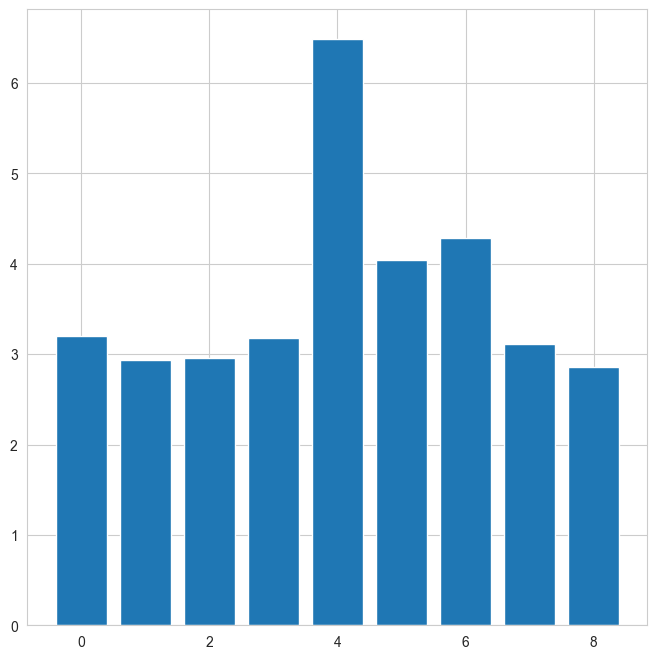

In [113]:
plt.bar(x = list(dict(g_docs.degree).keys()), 
                 height = list(dict(g_docs.degree(weight="weight")).values()))

If the network is not too dense, weights can be drawn into the plot to make it more informative.

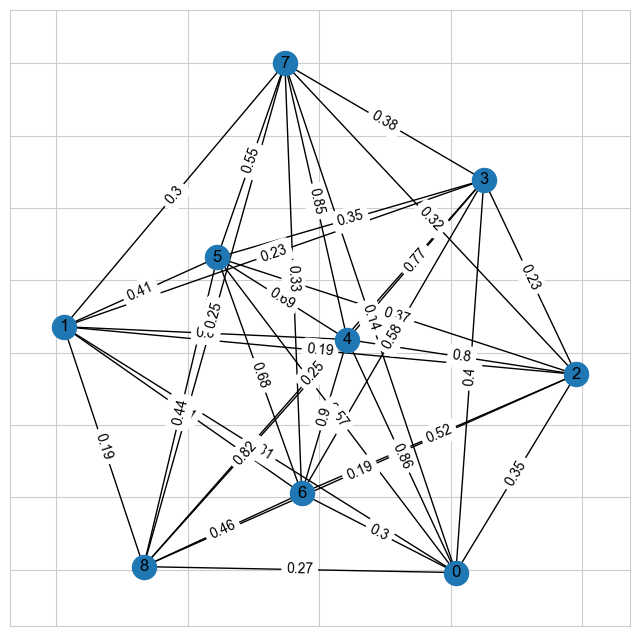

In [114]:
pos = nx.spring_layout(g_docs, seed=123)
nx.draw_networkx_nodes(g_docs, pos)
nx.draw_networkx_edges(g_docs, pos=pos)
labels = {e: np.round(g_docs.edges[e]['weight'],2) for e in g_docs.edges}
nx.draw_networkx_edge_labels(g_docs, pos, edge_labels=labels)
nx.draw_networkx_labels(g_docs, pos=pos);

In the past we stated that assessing centrality or community of fully connected networks can be pointless, for all the nodes are then by definition connected to all the other nodes, and so they will get identical scores. However in this case it is not pointless to assess the centrality or community of its nodes, because the edges have different weights. This is illustrated in the section on closeness centrality below.

Calculating shortest paths is different for weighted edges than for unweighted edges. In unweighted graphs it would be a matter of counting the steps on different paths and finding the one with the lowest number of steps, whereas in weighted graphs the procedure is to count the steps and multiply every step by its weight.

Also note that the weight can represent closeness or distance. If it represents distance, then one must simply multiply by it. If it represents closeness, we need to convert it into distance by using its reciprocal.

$$ distance = \frac{1}{closeness} $$ 

### F) Eccentricity and Network Diameter

Next we need to consider eccentricity. Eccentricity records the longest shortest path for every node. In the kite graph above, we can see that the eccentricity of node 9 is 4, as the maximum shortest path that exist between that node and some other node is four steps. Node 7, by contrast, has a maximum eccentricity of 2, as the longest shortest path that exist between it any other node is just 2.

Just as we can be interested in what is the center of a network, we can be interested in how large the network is. However, one cannot just "eye" a network graph to get a sense of its dimensions, because a graph can be plotted in many different ways and still be the same network.

The diameter of a network is very simple to calculate. It is just the maximum eccentricity value. A network is as wide as the longest shortest path that it includes. For the kite network, no node is further away than four steps from any other (that is the longest shortest path), and thus that is its diameter.

In [115]:
nx.diameter(g_kite)

4

## 2.2. Subgraphs

A graph can be broken down into subgraphs, which have the same (trivially) or less nodes than the original graph. This can be done by specifying the nodes you want to select. Here, for example, we  take the "tail" out of the kite, by not including nodes 7, 8, and 9 in the subgraph.

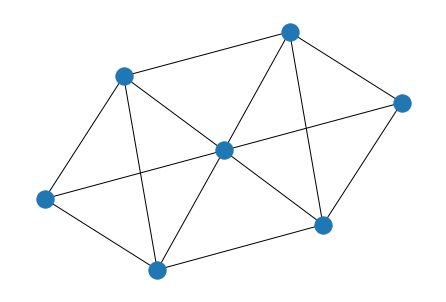

In [3]:
g_subkite = g_kite.subgraph([0,1,2,3,4,5,6])
nx.draw(g_subkite)

The kitegraph is a rather small graph and intuitive to interpret when visualized. The CJEU case law network is a larger one that is uninterpretable when all nodes are visualized.

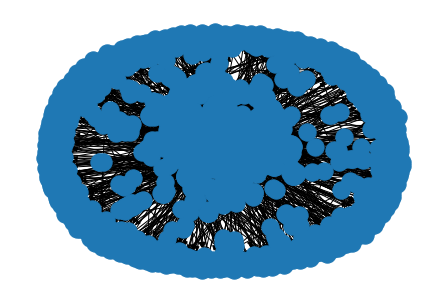

In [5]:
nx.draw(g_consprot)

One (!) way of making the network more comprehensible, is to create a subnetwork. Here, we create and plot a subnetwork of cases that have a degree score of at least 25, meaning that they have 25 or more incoming and outgoing citations combined. The network becomes much smaller now.

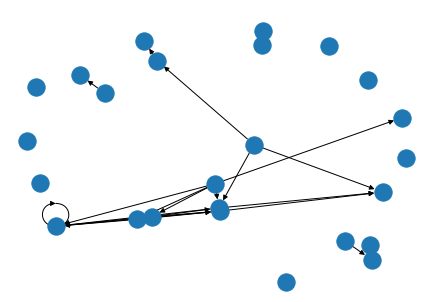

In [4]:
node_degree_dict=nx.degree(g_consprot)
g_consprot2=nx.subgraph(g_consprot,[x for x in g_consprot.nodes() if node_degree_dict[x]>=25])
# note: this code has already been run in the prerequsites section, but we are running it again here to exemplify the process of
# making a subgraph
nx.draw(g_consprot2)


Some nodes are disconnected from the other nodes. How is that possible considering we selected the cases with a degree score of 25 or more? Note that we did not filter (mask) the network where we instructed the machine to only display the nodes in the original graph with a degree of 25 or higher. Instead, we created a subgraph from which we removed the nodes with a lower degree. When the nodes are removed, the edges to the nodes are also removed, as a result of which the degree values of the nodes in the subnetwork also decreases (because they are not or less frequently cited by the remaining nodes) to the extent that nodes can have a degree of 0.

## 2.3 Flattening Bipartite Networks

A bipartite network has two types of nodes. One such example already introduced is states (node type 1) and treaties that they have ratified (node type 2). Such a network would look like this.

In [9]:
state_list

array(['Argentina', 'Belgium', 'China', 'Denmark', 'Ecuador', 'Finland',
       'Guyana', 'Netherlands', 'Paraguay', 'South Africa', 'USA',
       'Zimbabwe'], dtype=object)

## ERR why is nan showing up?

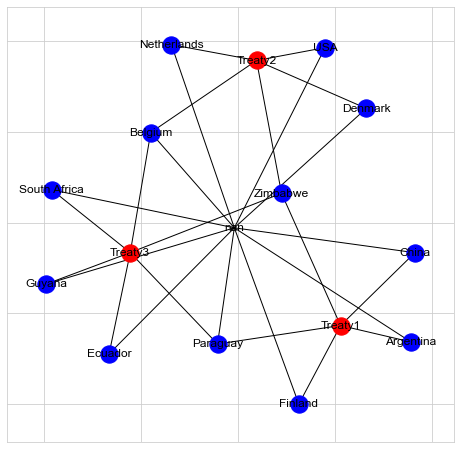

In [10]:
state_list = df_treaties.State.unique()
treaty_list = [x for x in df_treaties.treaty if not pd.isnull(x)]
plt.rcParams.update({'figure.figsize':(8,8)})
pos = nx.spring_layout(g_treaties, seed =123)
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist=state_list, node_color="blue")
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist=treaty_list, node_color="red")
nx.draw_networkx_edges(g_treaties, pos=pos)
nx.draw_networkx_labels(g_treaties, pos=pos);

Because of its bipartite form, such network cannot be easily analyzed using conventional methods such as centrality, edges to treaties and to countries are treated the same. One solution is to project the network into a single level, that is, to flatten it. 

Flattening involves removing the upper level nodes (treaties). Instead one creates connections between the lower level nodes (countries), weighted by how many upper level nodes they shared before.

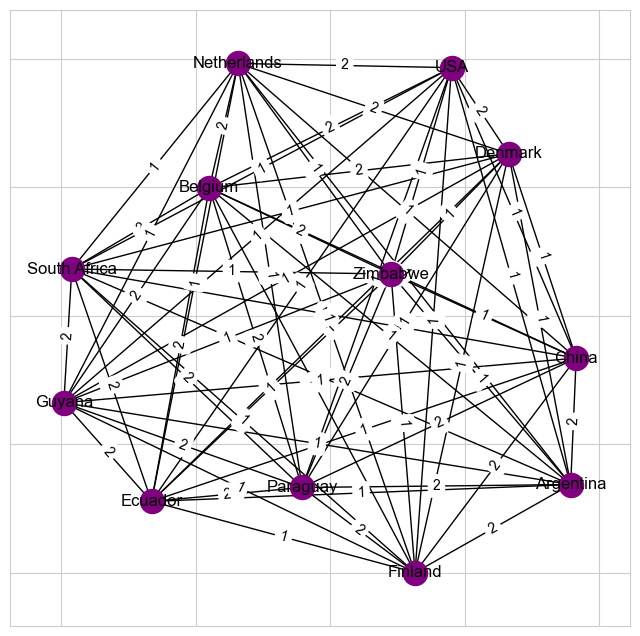

In [120]:
g_treaties_flat = nx.bipartite.weighted_projected_graph(g_treaties, nodes=state_list)
edgelabels = {(e,w):list(g_treaties_flat.get_edge_data(e,w).values())[0] for e,w in g_treaties_flat.edges}
pos = nx.spring_layout(g_treaties, seed =123)
nx.draw_networkx_nodes(g_treaties_flat, pos=pos, node_color="purple")
nx.draw_networkx_edges(g_treaties_flat, pos=pos)
nx.draw_networkx_labels(g_treaties_flat, pos=pos);
nx.draw_networkx_edge_labels(g_treaties_flat, pos, edge_labels=edgelabels);

Unlike the previous networks that we used, which were comprehensible, this network is not even that large yet it is difficult to interpret with the naked eye. For instance, it is difficult to determine whether this network is fully connected. A computation shows this is the case.

In [121]:
nx.is_connected(g_treaties_flat)

True

## 2.4 Network Metadata

Networks can store more than just node and edge information. The nodes and the edges can have attributes. We have already encountered one of such attributes, which is the "weight" attribute on an edge. The way such information is stored can be a bit hard to work with as it will almost always require the use of list comprehensions. However accessing such information we can query the network and visualize subnetworks that meet specific criteria. 

The NetworkX "view" objects are iterables that satisfy the requirements for comprehensions, but cannot be easily querried in other ways.

In [29]:
g_docs.edges(data="weight")

EdgeDataView([(0, 1, 0.3057850860342909), (0, 2, 0.3515643806261561), (0, 3, 0.4011441744419861), (0, 4, 0.8588650335933432), (0, 5, 0.5663867925847853), (0, 6, 0.3036944274298017), (0, 7, 0.1427956434168483), (0, 8, 0.2663586423650602), (1, 2, 0.1887291756697731), (1, 3, 0.2301873550390033), (1, 4, 0.800124882934437), (1, 5, 0.4122354734424759), (1, 6, 0.5097321851655097), (1, 7, 0.3027866619120244), (1, 8, 0.1868838597034725), (2, 3, 0.2280158058874547), (2, 4, 0.7995610591992457), (2, 5, 0.366590703499365), (2, 6, 0.5195230803085847), (2, 7, 0.317271203011655), (2, 8, 0.1896235506799158), (3, 4, 0.7678964587257362), (3, 5, 0.3480240462634174), (3, 6, 0.5762447937744228), (3, 7, 0.3808681395940203), (3, 8, 0.2481169176073587), (4, 5, 0.6878902741436519), (4, 6, 0.9008941138337112), (4, 7, 0.8540864919561113), (4, 8, 0.8214267919513534), (5, 6, 0.6824646015295808), (5, 7, 0.5453013285723745), (5, 8, 0.4356888455303136), (6, 7, 0.3289244386028924), (6, 8, 0.4649224309916062), (7, 8, 0.

In [37]:
mynodelist = [node for node, edge, weight in g_docs.edges(data="weight") if weight > 0.8]

For example here we will isolate the nodes that have an edge with a weight of more than 0.8 and see them as a subgraph or draw them as part of a graph with a different color.

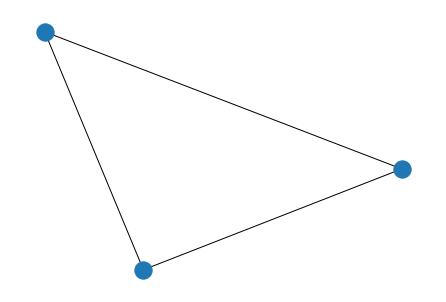

In [38]:
nx.draw(nx.subgraph(g_docs, mynodelist))

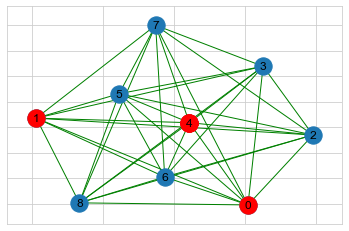

In [41]:
pos = nx.spring_layout(g_docs, seed=123)
nx.draw_networkx_nodes(g_docs, pos)
nx.draw_networkx_nodes(g_docs, nodelist=mynodelist, pos=pos, node_color="red")
nx.draw_networkx_edges(g_docs, pos=pos, edge_color='green')
nx.draw_networkx_labels(g_docs, pos=pos);

## Might have misidentified the nodes. Needs fixing

In [12]:
lh = pd.read_csv("data/legal_history.csv", sep=";")
lh.set_index("Unnamed: 0", inplace=True)
lh

,R16545,R16556,C10099,C10415,C10705,RRC4123,RLMech777,RLMech7781,RLMech7782,RLZutph1,...,RRInst416,RRC73212,RFHed125044,RFHed125045,RRC2320,RRD41247,RLFab771,RRD613,RRC2572,IRPlaccaat
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
R16545,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R16556,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C10099,0,1,0,0,0,1,1,1,1,1,...,1,3,4,2,1,1,1,0,0,0
C10415,1,1,1,0,0,1,1,0,0,0,...,0,3,3,2,0,0,0,1,1,1
C10705,0,0,0,1,0,0,0,0,0,0,...,0,2,1,1,0,0,0,0,0,0
RRC4123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RLMech777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RLMech7781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RLMech7782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
g_lh = nx.from_pandas_adjacency(lh, create_using= nx.DiGraph)

In [16]:
nx.set_node_attributes(g_lh, values = {"C10099":"source", "C10415":"source", "C10705":"source"}, name="type")

In [17]:
g_lh.nodes(data="type")

NodeDataView({'R16545': None, 'R16556': None, 'C10099': 'source', 'C10415': 'source', 'C10705': 'source', 'RRC4123': None, 'RLMech777': None, 'RLMech7781': None, 'RLMech7782': None, 'RLZutph1': None, 'RLVoet201': None, 'RRInst464': None, 'RRD6123': None, 'RRC236': None, 'RRD21438': None, 'RRAuthCod81324': None, 'RRAuthCod41014': None, 'RRNov41': None, 'RRNov42': None, 'RLPerez2': None, 'RRInst416': None, 'RRC73212': None, 'RFHed125044': None, 'RFHed125045': None, 'RRC2320': None, 'RRD41247': None, 'RLFab771': None, 'RRD613': None, 'RRC2572': None, 'IRPlaccaat': None}, data='type')

In [18]:
sourcenodes = nx.get_node_attributes(g_lh, "type").keys()
sourcenodes

dict_keys(['C10099', 'C10415', 'C10705'])

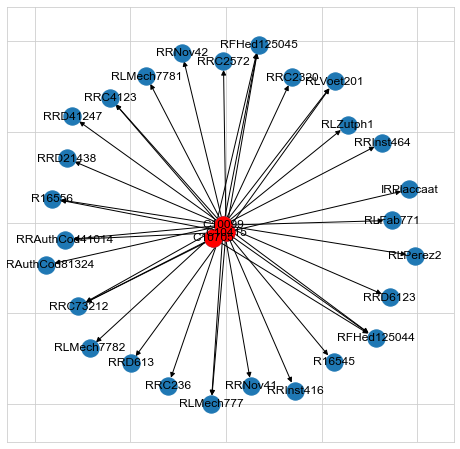

In [22]:
pos = nx.spring_layout(g_lh, seed=123)
nx.draw_networkx_nodes(g_lh, pos)
nx.draw_networkx_nodes(g_lh, nodelist=[x for x in sourcenodes], pos=pos, node_color="red")
nx.draw_networkx_edges(g_lh, pos=pos)
nx.draw_networkx_labels(g_lh, pos=pos);

# 3_Network_Centrality

As noted in Chapter 1, there are a variety of network centrality measures, and they capture different information. Which centrality measure to use, depends on the question one is interested in.

In Chapter 1, we introduced a number of centrality measures. In this chapter, we more thoroughly discuss these measures. We illustrate by means of examples. For those who are interested, we provide for basic mathematical explanations for the centrality measures. It is also possible to skip the math and to focus on the conceptual explanations provided below.

### 3.1 Degree and Degree Centrality

One might be interested in finding nodes, for instance court decisions, that are connected to a high number of other decisions, for instance by means of a reference (citation). The number of references in or to a certain decision may be an indication of the precedent value of that particular decision: nodes that are connected to a lot of other nodes might be considered better precedents than nodes that have less connections. **Degree** concerns assessing centrality by counting how many neighbors a node has. It is possible to calculate Degree for every node and to subsequently rank the results from the one with most neighbors to the one with the least. That is to say, to rank the nodes by looking at their degree: the number of nodes that are directly linked to it. 

Degree provides for an absolute value. For instance, a node can have a degree score of 1, 5, 673, or any other value for that matter. However, an absolute value might not always provide relevant information. For instance, a degree score of 5 is high if the network consists of 6 nodes, yet it is likely (but not necessarily) considered to be low if the network consists of 2,000,000 nodes. Having a score between 0 and 1, regardless of the degree value and the number of nodes in the network, would make the results in the example (degree=5, nodes=6 versus degree=5, nodes=2,000,000) comparable. This is often called "normalization" and this is what **degree centrality** scores reflect.

Degree centrality is the simplest of all the centrality scores, and it considers only the direct number of connections you have. It does not consider things like indirect connections, or the relative importance of those who connect to you. So for those we will have to look at other measures.

To obtain the Degree score, all one needs to do is count. It might be feasible to do this by hand in relatively small networks, yet it becomes unmanageable in larger networks. Software can then do the counting for us. Degree centrality normalizes this count dividing it by the total number of nodes (with some details discussed later)

For an easy illustration of how the calculation of degree and centrality measures looks in practice, we turn to an example of a 1970s karate club. This network arises from a sociological study of a karate club that would break up, with some students following the instructor and others the club president. What we are going to do here is to guess, using degree centrality, who might these two high profile club members be based on the number of friendships each karate club member has. For this, we can calculate the Degree scores for each individual node and subsequently rank the scores in a descending order (highest scores first, followed by the lower scores). We suspect that the individuals with the highest Degree scores might be the instructor and the president.

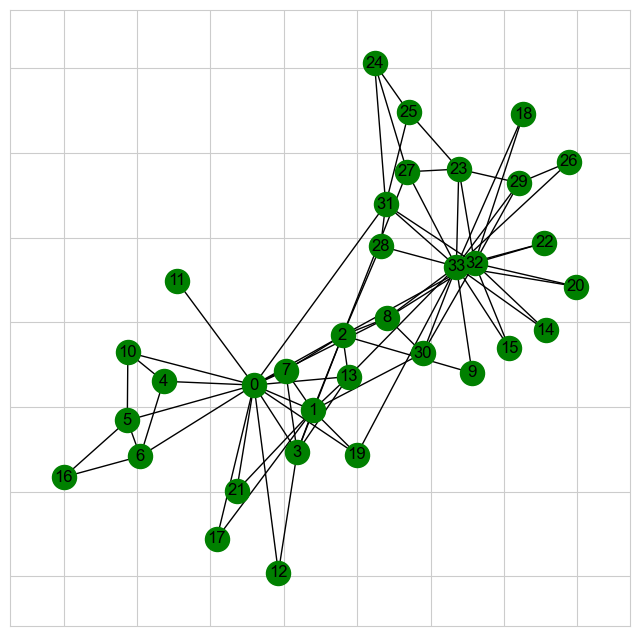

In [122]:
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, node_color="green")
nx.draw_networkx_edges(g_karate, pos=pos)
nx.draw_networkx_labels(g_karate, pos=pos);

In [123]:
degree = nx.degree(g_karate)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
centrality = nx.degree_centrality(g_karate)
centscore = list(dict(centrality).values())
resdf = pd.DataFrame({"node_id":nodeid, "degree":degscore, "deg_centrality":centscore})
resdf.set_index("node_id", inplace=True)
resdf.sort_values('degree', ascending=False)

,degree,deg_centrality
node_id,,
33,17,0.515
0,16,0.485
32,12,0.364
2,10,0.303
1,9,0.273
3,6,0.182
31,6,0.182
23,5,0.152
8,5,0.152


If the assumption is that club president and instructor are the individuals with the most friendships, we can look for the two nodes with the highest degree value. In the example, these are nodes 33 and 0.

We can do a similar exercise for a network of (some) train stations in the Netherlands.

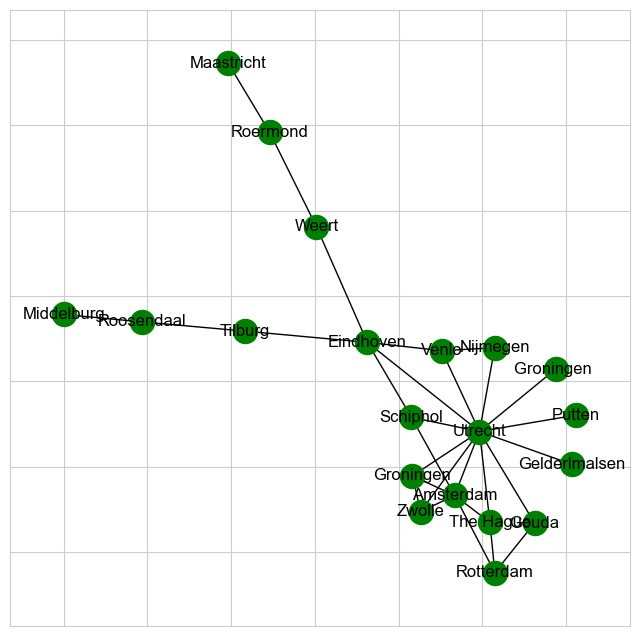

In [124]:
pos = nx.spring_layout(g_trains, seed =123)
nx.draw_networkx_nodes(g_trains, pos=pos, node_color="green")
nx.draw_networkx_edges(g_trains, pos=pos)
nx.draw_networkx_labels(g_trains, pos=pos);

We can calculate the degree for each station. There are 20 train stations in this dataset. When we ask NetworkX to calculate the results, we can see that Utrecht has the highest degree (degree=12).

In [125]:
degree = nx.degree(g_trains)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
centrality = nx.degree_centrality(g_trains)
centscore = list(dict(centrality).values())
resdf = pd.DataFrame({"node_id":nodeid, "degree":degscore, "deg_centrality":centscore})
resdf.set_index("node_id", inplace=True)
resdf.sort_values('degree', ascending=False)

,degree,deg_centrality
node_id,,
Utrecht,12,0.632
Amsterdam,6,0.316
Eindhoven,5,0.263
Groningen,3,0.158
Zwolle,3,0.158
The Hague,3,0.158
Rotterdam,3,0.158
Schiphol,3,0.158
Venlo,3,0.158


We conduct a simimlar analysis for the CJEU case law on consumer protection. Here, we can observe which cases (eg the cases with CELEX IDs 62001CJ0491 and 62003CJ0210, with CELEX being the ID assigned to cases) have the highest (and lowest) degree scores.

In [23]:
degree = nx.degree(g_consprot)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
centrality = nx.degree_centrality(g_consprot)
centscore = list(dict(centrality).values())
resdf = pd.DataFrame({"node_id":nodeid, "degree":degscore, "deg_centrality":np.round(centscore, 3)})
resdf.set_index("node_id", inplace=True)
resdf.sort_values('degree', ascending=False)

,degree,deg_centrality
node_id,,
62001CJ0491,80,0.050
62003CJ0210,72,0.045
61992CJ0091,53,0.033
62010CJ0618,47,0.029
62008CJ0040,46,0.029
...,...,...
62008CJ0201,1,0.001
62000CJ0255,1,0.001
62000CJ0327,1,0.001


#### A) Undirected degree centrality

The idea of degree centrality is wholly presented above. However lets introduce some notation, and some details.

One detail is that in its basic undirected form, degree centrality is the number of edges linking to a node divided by the number of nodes minus 1 (the -1 removes consideration of the node whose centrality is analyzed. The operation has very little practical difference, and some practical implementations will not bother to subtract 1).

In terms of notation, the degree centrality of a node can be represented by the following formula:

$$ \frac{degree(n)}{|N|-1}  $$

Here the large N refers to the set of all the nodes in the network. The small n refers to any particular node, whereas $ degree $ is a function that takes a node n, and returns how many edges link to that node.

A more precise way to denote Degree Centrality would be:

$$ \frac{degree(n)}{|N|-1} \mid n \in N $$

This denotation explicitly tells us that n is a node of N (the $ \in $ symbol states that n is an element of the set N). The vertical bars in $ |N| $ refer to the cardinality of the nodes in the network. In set theory, cardinality is simply the number of items a set has. So the cardinality of the set of colors blue, green, yellow is 3. The cardinality of the set of days in the week is 7, etc. Mathematical notation, however, is contextual. The vertical bars around N are sometimes used to mean something else (such as the vector norm), so one must interpret them in the context of what is being discussed.

Now we can put this in practice and do the formula by hand. For example looking back at the trains network, we can see that Maastricht has a degree of 1: there is only one station that links to Maastricht, in this case Roermond. So the result is simply: 

$$ \frac{degree(Maastricht)}{|N|-1} $$

or 

$$ \frac{1}{20-1} = 0.052 $$

What is the degree of Eindhoven? It is connected to Tilburg, Venlo, Utrecht, Schipol, and Weert, so it has a degree of 5. This means that its centrality score should be:

$$ \frac{degree(Eindhoven)}{|N|-1} $$

or 

$$ \frac{5}{20-1} = 0.26 $$

You can check above, and see that this is the same result that nx gives you.

#### B) Directed (in-degree and out-degree) centrality

Degree centrality considers the number of neighbors a node has, in relation to the total number of nodes. In directed networks, one can differentiate between in-degree (the number of nodes that point to a given node) and out-degree (the number of nodes that a given node points out to). In our case law network, we might expect that the number of incoming reference to a case is a good indicator or precedent value. Or we might be looking for cases that give an overview of existing case law, in which case we might want to look at the out-degree scores of the nodes, where higher scores indicate more references to other cases.

It can be useful to have a list of cases ordered by their "importance" (degree or centrality) in terms of incoming or outgoing edges. We illustrate with the case law example, where we can find the in-degree scores for the individual nodes. We can calculate the degree, in-degree, or out-degree centrality of all nodes in our case law network (ranked or unranked), but with a network of 1,614 the list can be rather long. 

Lets first print out the results sorted by in degree.

In [127]:
indegree = g_consprot.in_degree(g_consprot)
outdegree = g_consprot.out_degree(g_consprot)
nodeid = list(dict(indegree).keys())
indegscore = list(dict(indegree).values())
outdegscore = list(dict(outdegree).values())

incentrality = nx.in_degree_centrality(g_consprot)
incentscore = list(dict(incentrality).values())
outcentrality = nx.out_degree_centrality(g_consprot)
outcentscore = list(dict(outcentrality).values())

resdf = pd.DataFrame({"node_id":nodeid, 
                      "indegree":indegscore,
                      "outdegree": outdegscore,
                      "indeg_centrality":incentscore,
                      "outdeg_centrality":outcentscore})
resdf.set_index("node_id", inplace=True)
resdf.sort_values('indegree', ascending=False)


,indegree,outdegree,indeg_centrality,outdeg_centrality
node_id,,,,
61992CJ0091,46,7,0.029,4.340e-03
62003CJ0210,41,31,0.025,1.922e-02
62001CJ0491,40,40,0.025,2.480e-02
61994CJ0178,31,5,0.019,3.100e-03
62008CJ0040,30,16,0.019,9.919e-03
...,...,...,...,...
62011CJ0332,0,1,0.000,6.200e-04
62011CJ0419,0,1,0.000,6.200e-04
62011CJ0215,0,1,0.000,6.200e-04


Now lets do the same for out degree.

In [128]:
resdf.sort_values('outdegree', ascending=False)

,indegree,outdegree,indeg_centrality,outdeg_centrality
node_id,,,,
62001CJ0491,40,40,2.480e-02,0.025
62003CJ0210,41,31,2.542e-02,0.019
62006CJ0244,9,27,5.580e-03,0.017
62012CJ0470,15,24,9.299e-03,0.015
62014CJ0377,2,22,1.240e-03,0.014
...,...,...,...,...
62009CJ0185,1,0,6.200e-04,0.000
61996CJ0180,2,0,1.240e-03,0.000
62005CJ0152,4,0,2.480e-03,0.000


We can once more check manually what is going on. For this, we take the degree, in-degree, or out-degree, and divide it by the number of nodes in the network. For example:

$$ \frac{indegree(62003CJ0210)}{|N|-1} $$

or 

$$ \frac{41}{1614-1} = 0.025 $$

Below, we show the ten nodes with the highest in-degree centrality. We rank the nodes in descending order (node with the highest in-degree on top, followed by the node with the second-highest in-degree value, etc.). Note that the ranking is the same as above, where the in-degree scores were calculated. This can be explained by the fact that all in-degree scores are divided by the same value in the demoninator.

### 3.2 Closeness Centrality

Degree, in-degree, and out-degree (centrality) consider the direct neighbors of a node, but not indirect neighbors. For instance, if A is connected to B and B is connected to C, the indirect relationship between A and C (through) B might be relevant, whereas it is not taken into consideration in degree, in-degree, and out-degree (centrality). When searching for, for instance, precedents, it might not merely be interesting to look at how many citations it receives, directly or indirectly. Closeness centrality takes such indirect relationships into consideration.

Closeness centrality expresses the average distance between a node and all other nodes it can reach, taking the shortest path between two nodes (called 'geodesic path'). The lower the average distance of one node to all other nodes using the shortest paths, the more central the node is. The details on this are provided below.

The importance of closeness centrality becomes most evident when we have nodes that have a "tail" behind them. They have one direct neighbor, but many indirect neighbors standing in line behind them. This is literally what we see when do the analysis for the kite graph, with the tail of the kite being nodes 7, 8 and 9. Lets first recall the structure of this graph:

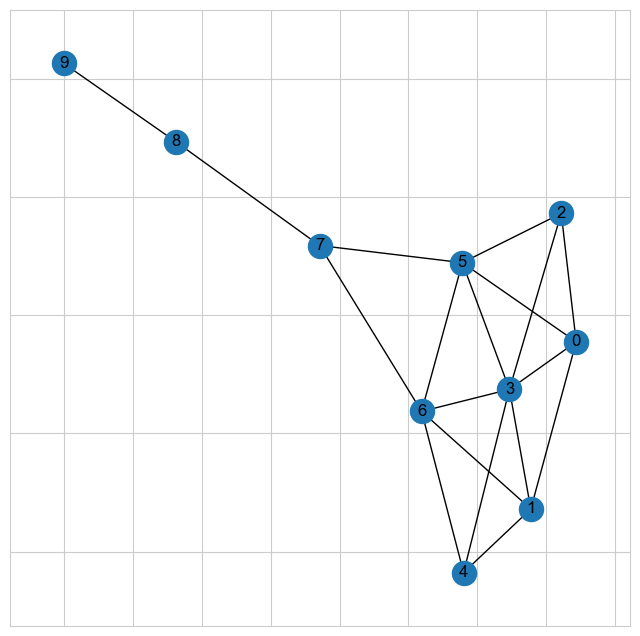

In [129]:
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos)
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In terms of degree, node 3 is the clear winner, with a degree of 6 and a degree centrality of 0.66. Node 7 is far behind on the 8th position.

In [130]:
degree = nx.degree(g_kite)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
degcentrality = nx.degree_centrality(g_kite)
degcentscore = list(dict(degcentrality).values())
reskite1 = pd.DataFrame({"node_id":nodeid, 
                      "degree":degscore, 
                      "deg_centrality":degcentscore})
reskite1.set_index("node_id", inplace=True)
reskite1.sort_values('degree', ascending=False)

,degree,deg_centrality
node_id,,
3,6,0.667
5,5,0.556
6,5,0.556
0,4,0.444
1,4,0.444
2,3,0.333
4,3,0.333
7,3,0.333
8,2,0.222


However one might think that node 7 is undervalued. It has only 3 direct neighbors, but it actually has many indirect neighbors, including nodes 8 and 9, that can only be reached by passing through 7. Lets see how 7 does when use this second form of centrality score.

In [131]:
degree = nx.degree(g_kite)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
degcentrality = nx.degree_centrality(g_kite)
degcentscore = list(dict(degcentrality).values())
closenesscent = nx.closeness_centrality(g_kite)
closescores = closenesscent.values()

reskite2 = pd.DataFrame({"node_id":nodeid, 
                      "degree":degscore, 
                      "deg_centrality":degcentscore,
                     "closeness_score":closescores})
reskite2.set_index("node_id", inplace=True)
reskite2.sort_values('closeness_score', ascending=False)

,degree,deg_centrality,closeness_score
node_id,,,
5,5,0.556,0.643
6,5,0.556,0.643
3,6,0.667,0.600
7,3,0.333,0.600
0,4,0.444,0.529
1,4,0.444,0.529
2,3,0.333,0.500
4,3,0.333,0.500
8,2,0.222,0.429


Things change quite a bit if we look at closeness centrality instead. 

Now node 7 moves up from being in the 8th position to being in the 4th! 

In fact other scores also change.  Node 3 is no longer the winner. Under closeness node 3 is penalized for having long paths for nodes 8 and 9. Nodes 5 and 6 obtain better scores. They have less nodes directly linking to them, but they are closer to the other nodes, which is what is relevant for closeness centrality.

One might intuitively say that node 7 is still underperforming in relation of its real importance. If we cut out node 7, the network becomes disconnected. This is not so if you cut any node from 0 to 6. This will come back when we consider betweenness centrality.

> So which one is better? Degree centrality or closeness? What is crucial to note for now is how different they are. Domain knowledge is needed to see which one matters most.


Here we can compare the relative performance of these two measures directly.

<AxesSubplot: xlabel='node_id', ylabel='closeness_score'>

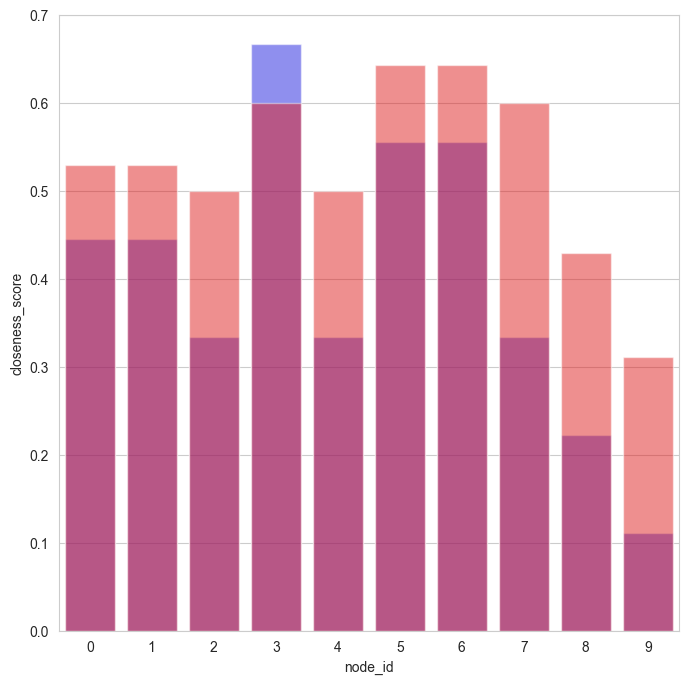

In [132]:
sns.barplot(x = reskite2.index, y = reskite2.deg_centrality, color='blue', alpha =0.5)
sns.barplot(x = reskite2.index, y = reskite2.closeness_score, color='red', alpha = 0.5)

Now lets try to unpack the algorithm in more detail.


As noted above, the library can calculate shortest paths for us. Here we get the number of steps.

In [133]:
nx.single_source_shortest_path_length(g_kite, source = 8)

{8: 0, 9: 1, 7: 1, 5: 2, 6: 2, 0: 3, 1: 3, 2: 3, 3: 3, 4: 3}

Or if you just want to see the itinerary, and not the number of steps:

In [134]:
nx.shortest_path(g_kite, 6, 8)

[6, 7, 8]

The formula to calculate closeness centrality is:

$$ \frac{|V|-1}{\sum_{spath(v_1,u)}^{spath(v_n, u)}} $$

In this formula, the number of nodes that can reach a certain node (called node u) minus 1, is divided by the sum of minimum path lengths between a specific node (node v) and a target node (node u), for every node that has a path to the target node (node u). The top part of the formula expresses the number (cardinality) of nodes that can reach node u (minus 1), whereas 'spath' in the bottom part of the formula refers to the **shortest path** (geodesic path) between two nodes. The latter is the smallest number of steps that you have to take from node v to reach node u. The number of steps are added up, as a result of which the sum of the shortest paths from node $ v_1 $ (a specific node) to node $ v_n $ (all other nodes it can reach) is returned.

$$ \sum_{a}^{d} $$ 
(Note that sums are normally expressed by a sigma notation rather than by a+b+c+d. The $ \Sigma $ means 'sum', the subscript (the a at the bottom) gives you the element where the sum begins, and the superscript (the letter at the top) the element where it ends.)

If we add a last specification (that v belongs to V) the formula might look like this:  

$$ \frac{|V|-1}{\sum_{spath(v_1,u)}^{spath(v_n, u)}} \mid v \in V $$

where 
$$ v \in V $$

indicates that all elements v that belong to the set V (the set of nodes that can reach node u).

#### A) Closeness with weights (distances)

We previously explained that edges can have weights and that networks can be fully connected. A network of document similarity has both features. Imagine we want to measure the semantic similarity between two cases, for instance because we want to compare how similar decisions are in terms of their facts, the reasoning, or simply on the document level.

What would be the expected result of running a centrality measure, such as closeness centrality, on this network without specifying any weight information? The result would be that all nodes are equally - maximally - close to each other. They would all be connected (degree=1) and equally close to each other (closeness=1), considering that all the cases have a similarity score: even though pairs of cases have different similarity scores, they all have *a* similarity score.

In [135]:
res = nx.closeness_centrality(g_docs)
res_view = [ (v,k) for k,v in res.items() ]
res_view.sort(reverse=True)
for v,k in res_view:
    print(f"for node {k} closeness score is {np.round(v,2)}")

for node 8 closeness score is 1.0
for node 7 closeness score is 1.0
for node 6 closeness score is 1.0
for node 5 closeness score is 1.0
for node 4 closeness score is 1.0
for node 3 closeness score is 1.0
for node 2 closeness score is 1.0
for node 1 closeness score is 1.0
for node 0 closeness score is 1.0


To avoid this uninformative result, it is possible to adjust the closeness metric considering the weights, with the weights indicating document similarity (the higher the weight, the more similar the document).

In [136]:
res = nx.closeness_centrality(g_docs, distance='weight')
res_view = [ (v,k) for k,v in res.items() ]
res_view.sort(reverse=True)
for v,k in res_view:
    print(f"for node {k} closeness score is {np.round(v,2)}")

for node 8 closeness score is 2.8
for node 1 closeness score is 2.72
for node 2 closeness score is 2.7
for node 7 closeness score is 2.57
for node 3 closeness score is 2.52
for node 0 closeness score is 2.5
for node 5 closeness score is 1.98
for node 6 closeness score is 1.87
for node 4 closeness score is 1.23


It is good to know that closeness centrality takes into consideration how well-connected a node is (the numerator of the formula increases when more nodes can reach the node of interest). Consider the following example, where nodes D and E have a single very short path between them. This path is very short, but it is penalized by the very small numerator, as D and E can only be reached by one other node.

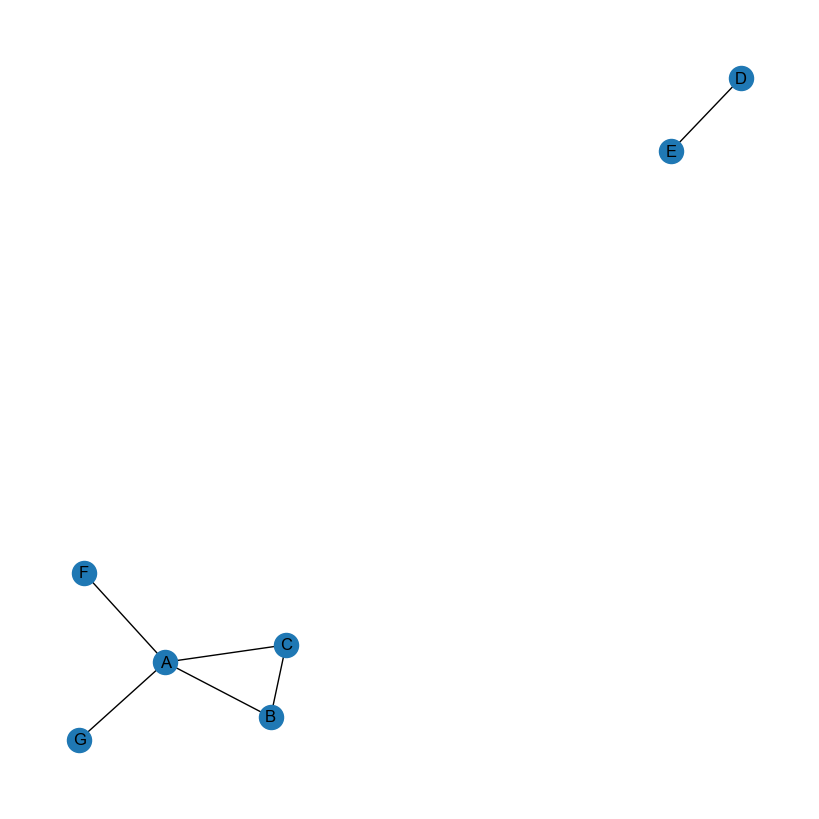

In [137]:
g_disconnected2 = nx.Graph()
g_disconnected2.add_nodes_from(['A','B','C','D','E','F','G'])
g_disconnected2.add_edges_from([('A','B'),('B','C'), ('C','A'), ('A','F'),('A','G'),('D','E')])

pos = nx.spring_layout(g_disconnected2, seed=123)
nx.draw(g_disconnected2, pos=pos)
nx.draw_networkx_labels(g_disconnected2, pos=pos);

In [138]:
nx.closeness_centrality(g_disconnected2)

{'A': 0.6666666666666666,
 'B': 0.4444444444444444,
 'C': 0.4444444444444444,
 'D': 0.16666666666666666,
 'E': 0.16666666666666666,
 'F': 0.38095238095238093,
 'G': 0.38095238095238093}

## 3.3 Eigenvector Centrality

Another approach to determine the centrality of a node is to consider how likely it is to reach that node if one would randomly 'walk' through the network. If a node would be reached more frequently than other nodes, this could signal that the node is more central and consequently more relevant. 

Eigenvector centrality is based on this 'random walker' idea. Each node has a percentage value that corresponds to the likelihood that a 'random walker' within the network would find itself at a particular node at a particular point in time. As a result, each node is given a score based on the number of 

## Doubt: I am not sure about this. I think eigenvector centrality only works in undirected graphs, thus incoming and outcoming edges do not play a role.

> incoming edges, whereby 'support' from high-scoring nodes is given more weight than support from lower-scoring nodes, with the value of support given is diluted by the number of outgoing edges. 

Eigenvector centrality is arrived at by simulating the propagation of views across the network. It simulates a random walker moving from node to node, each time with equal probability of going to the adjacent node. The idea is that if the walk goes on for very long, the probability of seeing the walker at a particular node will stabilize, giving you the Eigenvector Centrality value. 

To illustrate, we calculate the Eigenvector Centrality scores for the train stations. 

In [139]:
res = nx.eigenvector_centrality(g_trains)
resdf = pd.DataFrame({"station":res.keys(), "score":res.values()})
resdf.set_index("station")
resdf.sort_values('score', ascending=False)

,station,score
1,Utrecht,0.569
0,Amsterdam,0.390
9,Groningen,0.267
15,Zwolle,0.267
19,Schiphol,0.264
4,Eindhoven,0.254
14,The Hague,0.247
6,Venlo,0.217
13,Rotterdam,0.174
7,Nijmegen,0.171


Now lets remember that degree centrality favors the number of direct neighbors one has, closeness centrality takes into account indirect networks, including thus nodes that are in a "tail" formation behind a node. Eigenvector centrality has an iterative nature (where is the random walker likely to be after many walks), and what this does, is that it takes into account the relative importance of nodes. A node gets a high eigenvector centrality score if it is linked to other nodes which also have a high eigenvector centrality score. So the intuition is that here being "famous" is defined in terms of having many friends who are also "famous". 

Lets go back to the kite and remember that:
* Degree centrality prefers node 3, and puts node 7 far on the back.
* Closeness prefer both 5 and 6, and puts node 7 in 4th place
Now we will see that
* Eigenvector centrality prefers node 3, and also puts node 7 far on the back.

Note why this might be so. Node 3 not only has high degree, but it is also close to nodes 5, 6, 0 and 1, which also have high degree. By contrast node 7 is "friends" with 5 and 6, but also with the unpopular 8, so it can rank as high.


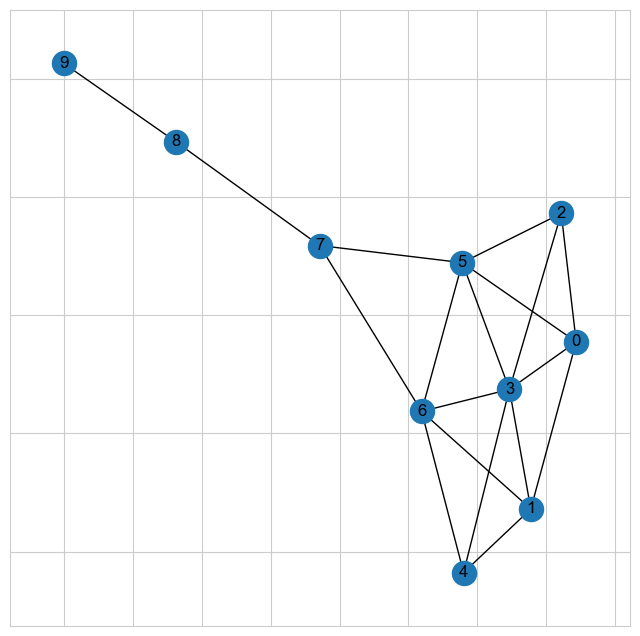

In [141]:
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos)
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

We can see the scores here.

In [142]:
degree = nx.degree(g_kite)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
degcentrality = nx.degree_centrality(g_kite)
degcentscore = list(dict(degcentrality).values())
closenesscent = nx.closeness_centrality(g_kite)
closescores = closenesscent.values()
eigcentrality = nx.eigenvector_centrality(g_kite)
eigscore = list(dict(eigcentrality).values())
reskite3 = pd.DataFrame({"node_id":nodeid, 
                      "degree":degscore, 
                      "deg_centrality":degcentscore,
                         "closeness_cent": closescores,
                        "eig_centrality":eigscore})
reskite3.set_index("node_id", inplace=True)
reskite3.sort_values('eig_centrality', ascending=False)

,degree,deg_centrality,closeness_cent,eig_centrality
node_id,,,,
3,6,0.667,0.600,0.481
5,5,0.556,0.643,0.398
6,5,0.556,0.643,0.398
0,4,0.444,0.529,0.352
1,4,0.444,0.529,0.352
2,3,0.333,0.500,0.286
4,3,0.333,0.500,0.286
7,3,0.333,0.600,0.196
8,2,0.222,0.429,0.048


The mathematics of Eigenvector Centrality are complicated, in particular for non-technical persons. We are not going to present it in full, but we will, in the next example, sketch an idea of how Eigenvector Centrality works and some ways of arriving at it. 

In its simplest form, Eigenvector Centrality is what you get by repeatedly multiplying: 

* an **adjacency matrix** by 
* a **vector of probabilities** associated with each node.

Let us use a small network to illustrate. Imagine we have four nodes "a", "b", "c" and "d", and we are making a network of their linkages. We begin representing this network as a $ 4 \times 4 $ adjacency matrix "A" (it is customary to represent matrices with capital letters). In this matrix a 1 indicates there is a connection between a node in the rows and another in the columns, and a 0 means that there is no connection. If one picks node "a" in the rows, we see that it connects to "b" and "d" in the columns. If we read the row of node "b", we see that it connects with "a" and "d" in the columns. And so on. 

$$ A = \pmatrix{
0 & 1 & 0 & 1 \\ 
1 & 0 & 0 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
} $$

For the vector of initial probabilities "v" we can just assume that one is equally likely to be in each of the four rows of the matrix.

$$ v = \pmatrix{0.25,0.25,0.25,0.25} $$

The basic idea is that if one multiplies "A" and "v" one will "apply" the probabilities of the contingency matrix to the vector, or "scale" the vector by the probability matrix. If one does this multiple times, thousands of times, the values will "converge", which means they will not change much from multiplication to multiplication. 

$$ v := A \times v $$ 

Afterwards the vector can be "normalized" by dividing it by its norm: 

$$ \frac{v}{||v||} $$

The result represents the eventual stable position of many repeated random walks. This should be more or less the same as what software gives you.

Why is this called Eigenvector Centrality? Because a property of the adjacency matrix, namely, the Eigenvector associated with its highest Eigenvalue, will give the same results as the (brute force) method presented above.

### 3.3.1 Scaling and normalization

Let's provide some intuition for some of the operations discussed above. First let us zoom in on matrix-vector multiplication.

A matrix applied to a vector by multiplication transforms the vector, for example by extending or shrinking it, changing its direction or flipping it around. 

(The rules for matrix multiplication are very simple arithmetic, and can found on a quick search.)

Let us first create a small vector, and then scale it using a $2 \times 2$ matrix

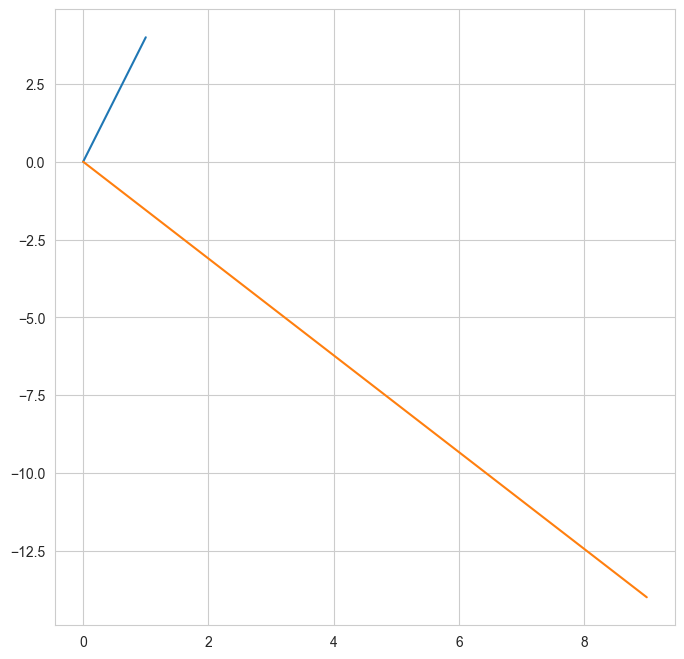

In [143]:
B = np.array([[1,2],[2,-4]])
myvec = np.array([1,4])
myvec_scaled = B@myvec

plt.plot([0, myvec[0]], [0, myvec[1]])
plt.plot([0, myvec_scaled[0]], [0, myvec_scaled[1]])

So here we see the vector got flipped and extended. We could do this process again...

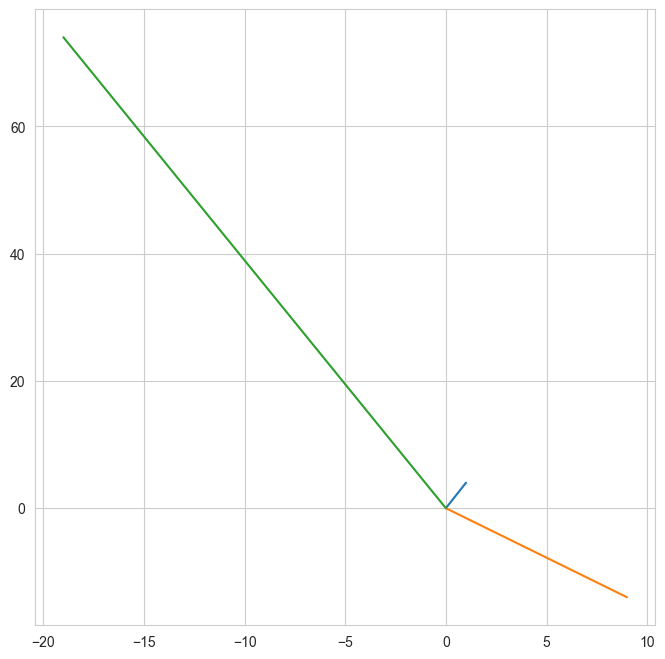

In [144]:
myvec_scaled2 = B@myvec_scaled
plt.plot([0, myvec[0]], [0, myvec[1]])
plt.plot([0, myvec_scaled[0]], [0, myvec_scaled[1]])
plt.plot([0, myvec_scaled2[0]], [0, myvec_scaled2[1]])


And again... and see if at some point it does not really change direction anymore (magnitude might change, but that is not what we are looking for).

Our initial vector of probabilities was four dimensional, so it cannot be plotted here, but what we want to find is what happens to this vector of probabilities when after many matrix multiplications (many scalings) it stabilizes into its final orientations.

Let us also quickly explain what normalization does. 

A vector has a direction and a magnitude. It is used to represent data. We are most familiar with 2d or 3d vectors from geometry, but what is done geometrically to them, can still be done for vectors with more dimensions.

Let's plot here 3 vectors pointing in different directions

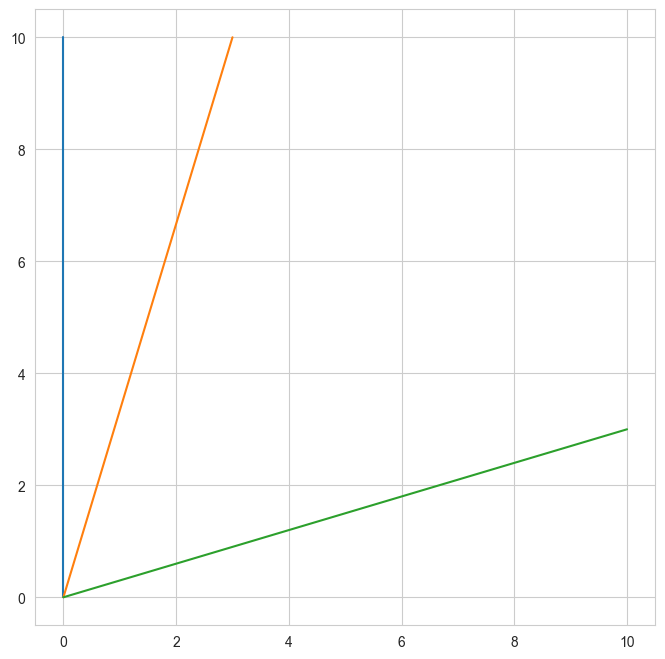

In [145]:
vec1 = np.array([0,10])
vec2 = np.array([3,10])
vec3 = np.array([10,3])

plt.plot([0, vec1[0]], [0, vec1[1]])
plt.plot([0, vec2[0]], [0, vec2[1]])
plt.plot([0, vec3[0]], [0, vec3[1]])


To get the magnitude or length of a vector, that is, its "norm" we can use Pythagoras theorem and square root the sum of its length and height so:

$$ ||v||  = \sqrt{(x^2 + y^2)} $$ 

Once we get this vector norm, we can divide each element of the vector by it, to get a vector that has a magnitude of 1, also called a unit vector.

$$ \frac{v}{||v||} $$

The vector so modified conserves its direction, but its magnitude is "standarized" to 1. Compare the vectors presented earlier to the ones in red:

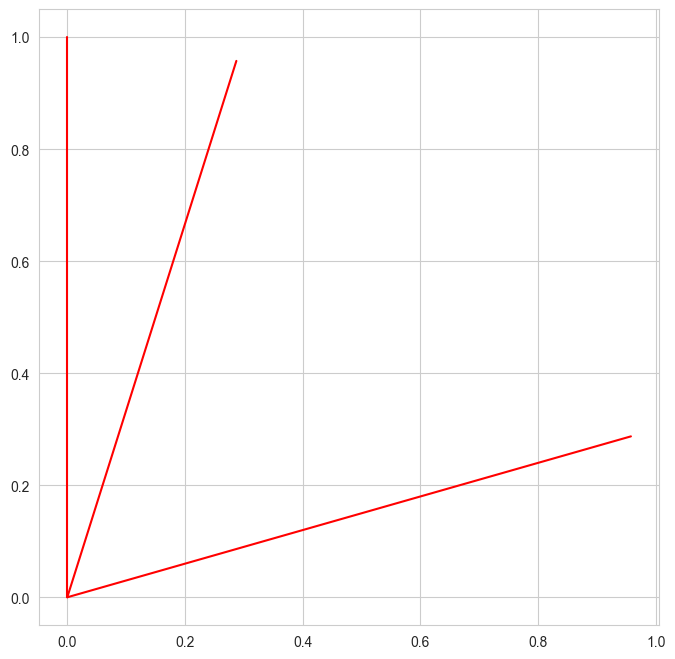

In [146]:
norm_vec1 = np.linalg.norm(vec1)
norm_vec2 = np.linalg.norm(vec2)
norm_vec3 = np.linalg.norm(vec3)

vec4 = vec1/norm_vec1
vec5 = vec2/norm_vec2
vec6 = vec3/norm_vec3

plt.plot([0, vec4[0]], [0, vec4[1]], color="red")
plt.plot([0, vec5[0]], [0, vec5[1]], color="red")
plt.plot([0, vec6[0]], [0, vec6[1]], color="red")

### 3.3.2 Putting things in practice

Let us put the procedure in practice. We first create the adjacency matrix of the kite graph.

In [147]:
A = nx.adjacency_matrix(g_kite)
A.todense()

C:\Users\gijs.vandijck\AppData\Local\Temp\ipykernel_1480\3189358813.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(g_kite)


matrix([[0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=int32)

The next step is to have an initial vector of probabilities. Each element of this vector should be 1/10 or 0.1. Remember that probabilities have to sum to 1, and if it is equally probable that one may be in each of the 10 nodes of the kite graph, then we have a 0.1 probability for each.

In [148]:
v = (np.ones(10)/10)
v

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Finally we repeatedly multiply the adjacency matrix by the vector of probabilities and normalize the results. We will just do it 100 times. In more complicate scenarios, more repetitions might be required to do the trick.

In [149]:
for i in range(0,100):
    v = A@v
mynorm = np.linalg.norm(v)
res = v / mynorm
res

array([0.3522094 , 0.3522094 , 0.28583499, 0.48102086, 0.28583499,
       0.39769064, 0.39769064, 0.19586058, 0.04807349, 0.01116326])

NetworkX gives the results directly:


In [150]:
nx.eigenvector_centrality(g_kite)

{0: 0.3522089813920359,
 1: 0.3522089813920358,
 2: 0.28583473531632403,
 3: 0.48102048812210046,
 4: 0.28583473531632403,
 5: 0.3976910106255469,
 6: 0.39769101062554685,
 7: 0.19586185175360382,
 8: 0.048074775014202924,
 9: 0.011164058575824235}

Finally let us approach it from the perspective of eigenvalues and eigenvectors. 

Eigenvalues and eigenvectors are a property of certain matrices, which are complicated to get by hand, but which numpy can provide on command.

Eigenvectors are just vectors, that when multiplied by the matrix ($ matrix \times vector $), scale, but do not rotate it. 

Every eigenvector will have an eigenvalue -just a number- associated with it. Here we are interested in the eigenvector that is associated with the largest eigenvalue

The largest eigenvalue here is 4.3. This is in index position 0 of the numpy array (arrays like a python list, start from zero). 

In [151]:
vals, vecs = np.linalg.eig(A.todense())
vals

array([ 4.30640379,  1.60639741,  1.41421356,  0.64036468, -0.40434195,
       -0.816375  , -2.        , -1.41421356, -1.46406328, -1.86838565])

If we see the eigenvector that is in position 0 (corresponding to the largest eigenvalue that we recall was in index position 0), we again get the result we are looking for. 


In [152]:
vecs[:,0]

matrix([[0.3522094 ],
        [0.3522094 ],
        [0.28583499],
        [0.48102086],
        [0.28583499],
        [0.39769064],
        [0.39769064],
        [0.19586058],
        [0.04807349],
        [0.01116326]])

Note what is going on here code wise. ```vecs``` gives us all the eigenvectors. 

In [153]:
vecs

matrix([[ 3.52209397e-01,  1.89445487e-01, -3.53553391e-01,
          2.50475739e-01,  5.05030447e-01,  7.62482192e-02,
          5.00000000e-01, -3.53553391e-01,  1.27468135e-01,
         -1.42542367e-02],
        [ 3.52209397e-01,  1.89445487e-01,  3.53553391e-01,
          2.50475739e-01,  5.05030447e-01,  7.62482192e-02,
         -5.00000000e-01,  3.53553391e-01,  1.27468135e-01,
         -1.42542367e-02],
        [ 2.85834991e-01,  1.16760682e-01, -5.00000000e-01,
          9.77805840e-02, -3.42822530e-01, -3.38990557e-01,
         -5.29162879e-16,  5.00000000e-01,  4.02146483e-01,
         -3.06688753e-02],
        [ 4.81020858e-01,  1.68769387e-01, -2.25358141e-16,
          1.21495199e-01, -2.55950827e-01, -1.05180509e-01,
          1.21686335e-16,  4.47708213e-15, -6.96430792e-01,
          4.04703757e-01],
        [ 2.85834991e-01,  1.16760682e-01,  5.00000000e-01,
          9.77805840e-02, -3.42822530e-01, -3.38990557e-01,
          3.69558846e-16, -5.00000000e-01,  4.021464

Each of the eigenvectors (associated with every eigenvalue) is in a column. Using ```vecs[:,0]``` tell us "give me all the rows, under column zero.

In [154]:
vecs[:,0]

matrix([[0.3522094 ],
        [0.3522094 ],
        [0.28583499],
        [0.48102086],
        [0.28583499],
        [0.39769064],
        [0.39769064],
        [0.19586058],
        [0.04807349],
        [0.01116326]])

## 3.4 PageRank

PageRank is a variant of the Eigenvector centrality which uses in-degree centrality (backlinks) as a relative measure of influence and thus is applied to directed networks. The PageRank algorithm is based on the idea that important pages are linked to more often by other pages. Intuitively, the rank of a page corresponds to the likelihood of a user ending up on that page by randomly clicking from link to link. PageRank used to form the basis for the Google search engine algorithm.

Here we can see PageRank applied to the subgraph of our CJEU case law network.

In [155]:
nx.pagerank(g_consprot2)

{'61994CJ0178': 0.01770145389833906,
 '62000CO0345': 0.01770145389833906,
 '62011CJ0415': 0.020710749049946322,
 '62010CJ0618': 0.031594384596854805,
 '62011CJ0092': 0.022716945817684495,
 '62014CJ0169': 0.01770145389833906,
 '62007CJ0487': 0.03274792965637538,
 '62010CO0076': 0.04132372041936025,
 '62008CJ0040': 0.41258056209043453,
 '61984CJ0178': 0.03274792965637538,
 '62012CJ0470': 0.020710749049946322,
 '62008CJ0317': 0.020710749049946322,
 '62002CJ0434': 0.01770145389833906,
 '61992CJ0091': 0.01770145389833906,
 '62007CJ0343': 0.01770145389833906,
 '62003CJ0402': 0.037011188197463414,
 '62008CJ0484': 0.04923178632279343,
 '62004CJ0033': 0.01770145389833906,
 '62013CJ0026': 0.01770145389833906,
 '62001CJ0491': 0.0477944054144117,
 '61989CJ0241': 0.01770145389833906,
 '62009CJ0324': 0.01770145389833906,
 '62003CJ0211': 0.01770145389833906,
 '62003CJ0210': 0.01770145389833906,
 '62006CJ0244': 0.01770145389833906}

PageRank incorporates a "teleportation" factor: As a random walker moves through the network, it may get stuck on a node or nodes that has only incoming links to it, and no outgoing links. For example, once you reach a certain court decision, you just stay there, as the decision does not cite other decisions and consequently does not have any outgoing links. 

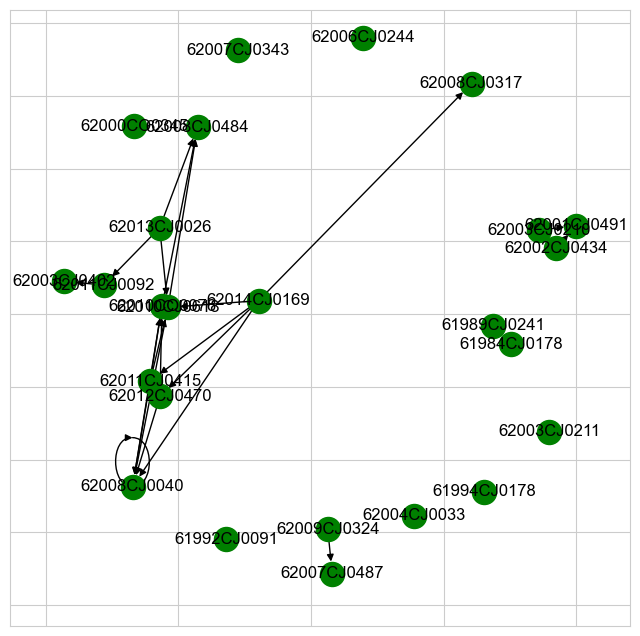

In [156]:
pos = nx.spring_layout(g_consprot2, seed =123)
nx.draw_networkx_nodes(g_consprot2, pos=pos, node_color="green")
nx.draw_networkx_labels(g_consprot2, pos=pos)
nx.draw_networkx_edges(g_consprot2, pos=pos);

Such a sink node can then absorb everything, as a result of with the PageRank score can drop to 0. To correct for this, the standard pagerank model gives a small random percentage of "teleporting" to any node in the network. The default value for this in NetworkX is 0.15. 

PageRank involves more complications than Eigenvector Centrality, so here we will only explain the core idea.

The first thing PageRank needs, is to transform the adjacency matrix into a transition matrix. While an adjacency matrix will record a 1 if there is a connection between a node in the rows and a node in the column, the transition matrix will record the probability of jumping from a node in the rows to another one in the columns in such a way that the probabilities all sum to 1. 

Imagine once more we have four metro stations A, B, C, D, that are connected as follows:

$$ A = \pmatrix{
0 & 1 & 0 & 1 \\ 
1 & 0 & 0 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
} $$

If we are in station A (first row), we can jump to station B or D. If we are in station B (second row) we can jump to station A and D. Granting equal probability of making that jump, we now weight the connection in terms of probabilities as in this manner:

$$ T = \pmatrix{
0 & 0.5 & 0 & 0.5 \\ 
0.5 & 0 & 0 & 0.5 \\ 
\frac{1}{3} & \frac{1}{3} & 0 & \frac{1}{3} \\ 
0 & 0.5 & 0.5 & 0 \\ 
} $$

Note that each row will sum to 1 as per the rules of probability.

Just like with Eigenvector centrality, the next thing needed is a vector that reflects the probability of being in each of the nodes of the network. There are four nodes, so a vector with equal probability will be a vector of 0.25s.

$$ v = \pmatrix{
0.25 & 0.25 & 0.25 & 0.25 \\ 
} $$

What needs to be done next is to multiply the vector of probabilities by the transition matrix many times. 

$$ v := T^T \times v $$

Just like with Eigenvector Centrality, eventually the values of v will not change much from multiplication to multiplication, and these rules when stabilized will represent the pagerank score.

## 3.5 Betweenness Centrality

So far we have been thinking of centrality in relation to the number of neighbors a node has. 
1. Degree centrality simply focuses on the number of direct neighbors a node has.
2. Closeness centrality takes into account not just direct neighbors, but also indirectly linked nodes.
3. Eigenvector centrality and Pagerank consider the connectedness or "fame" of the neighbors.

Now we will introduce a different focus. We will consider as most important not just nodes that have a lot of neighbors, but nodes that are "mediators", or "brokers" in the network. These are nodes that hold the network together. If they are deleted, this will cause severe disruption in the network, possibly disconnecting parts of the network. Betweenness centrality considers this broker status. In the law, for instance case law, betweenness centrality can be used to measure which court decisions have played a pivotal role in the development of a certain legal topic or area of the law, for instance consumer protection, intent in criminal law, data protection law, or negligence.

To illustrate how betweenness centrality can be determined or explained, we start with the example of actual political brokerage. The "Florentine Families" graph is a study of marriage alliances between families in Renaissance Florence. However, the visualization of the graph does not immediately allow us to see the dominance of the Medici...

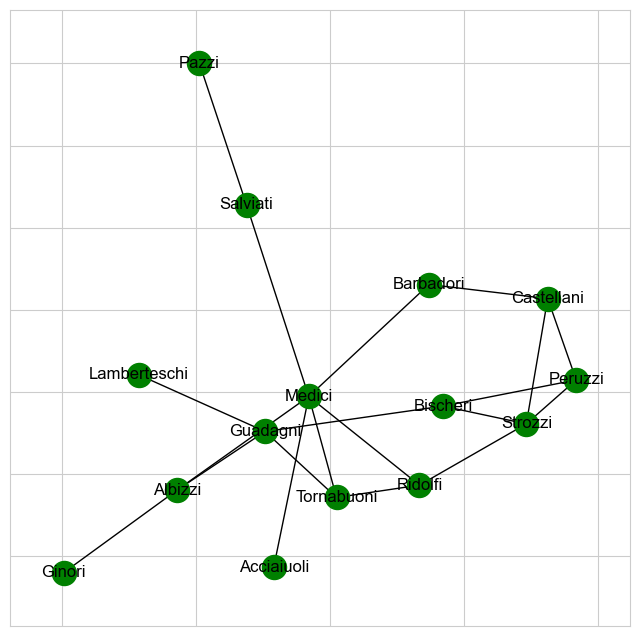

In [157]:
pos = nx.spring_layout(g_florentine, seed =123)
nx.draw_networkx_nodes(g_florentine, pos=pos, node_color="green")
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

Conventional centrality measures will show that the Medici have a stronger political situation, but they might understate their dominance. The closeness score for Medici is 0.56, but Strozzi, Barbadori, Ridolfi, Tornabuouni, Albizzi and Guadagni are not far behind.

In [158]:
medici = pd.DataFrame({'families':nx.closeness_centrality(g_florentine).keys(), 
                       'closeness':nx.closeness_centrality(g_florentine).values()})
medici

,families,closeness
0,Acciaiuoli,0.368
1,Medici,0.560
2,Castellani,0.389
3,Peruzzi,0.368
4,Strozzi,0.438
5,Barbadori,0.438
6,Ridolfi,0.500
7,Tornabuoni,0.483
8,Albizzi,0.483
9,Salviati,0.389


Once we factor in betweenness, the scores for the aforementioned families drop significantly and we get far better impression of the dominance of the Medici.

In [159]:
medici = pd.concat([medici, pd.Series(nx.betweenness_centrality(g_florentine).values())], axis=1).rename({0:"betweenness"}, axis=1)
medici

,families,closeness,betweenness
0,Acciaiuoli,0.368,0.000
1,Medici,0.560,0.522
2,Castellani,0.389,0.055
3,Peruzzi,0.368,0.022
4,Strozzi,0.438,0.103
5,Barbadori,0.438,0.093
6,Ridolfi,0.500,0.114
7,Tornabuoni,0.483,0.092
8,Albizzi,0.483,0.212
9,Salviati,0.389,0.143


Here we can see the massive contrast. The blue bars highlight the closeness centrality, and the red bars betweenness centrality. (If a blue bar exceeds a red bar, this indicates the extent to which the closeness centrality score is higher than the betweenness centrality score.)

<AxesSubplot: xlabel='betweenness', ylabel='families'>

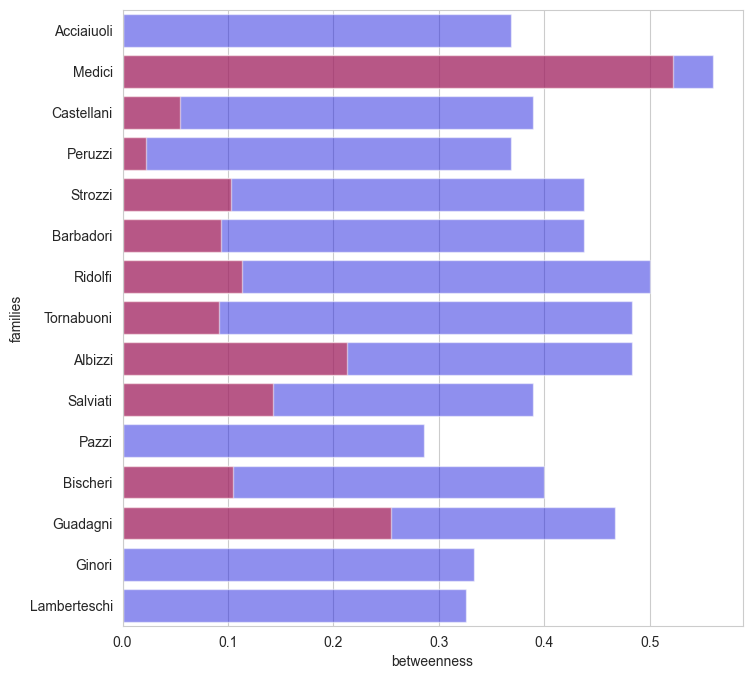

In [160]:
sns.barplot(y = medici.families, x = medici.closeness, color='blue', alpha =0.5)
sns.barplot(y = medici.families, x = medici.betweenness, color='red', alpha = 0.5)

Finally, let's see what happens when we remove the Medici family from the graph. As we can see, the graph suddenly becomes disconnected.

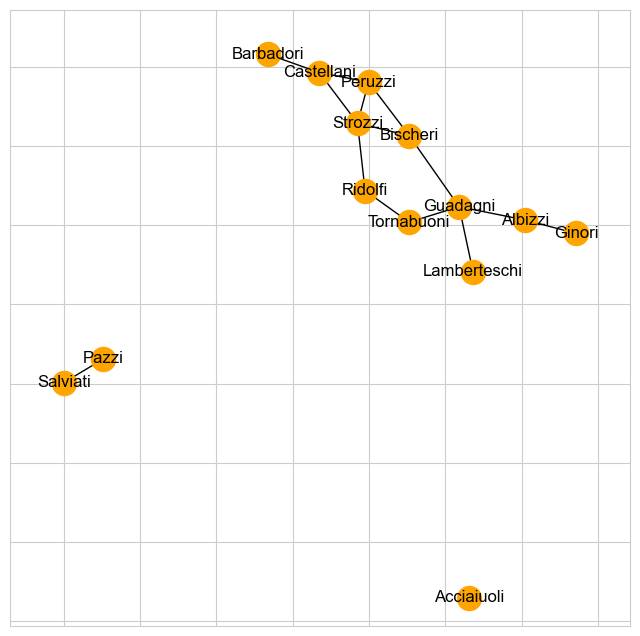

In [161]:
g_subflorentine = g_florentine.subgraph([x for x in g_florentine.nodes if not x=="Medici"])
pos = nx.spring_layout(g_subflorentine, seed =123)
nx.draw_networkx_nodes(g_subflorentine, pos=pos, node_color="orange")
nx.draw_networkx_edges(g_subflorentine, pos=pos)
nx.draw_networkx_labels(g_subflorentine, pos=pos);

We can perform a similar analysis for the subgraph of our CJEU case law network. We start with a comparison between the closeness and betweenness centrality scores of the cases. We first display the network.

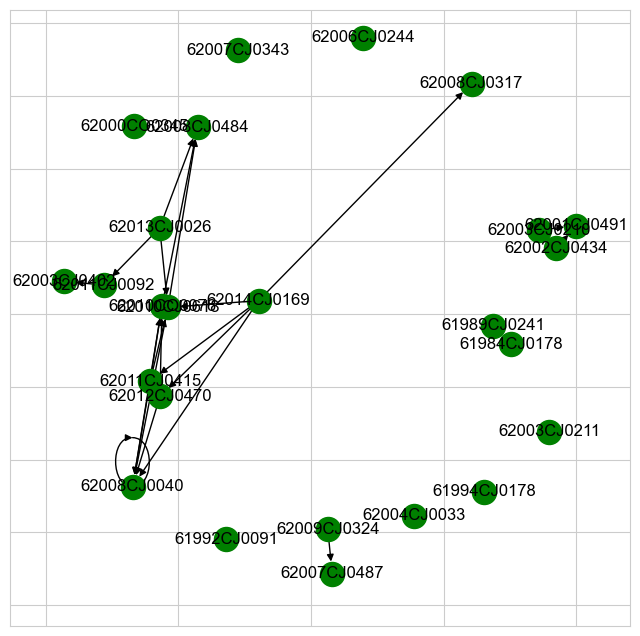

In [162]:
pos = nx.spring_layout(g_consprot2, seed =123)
nx.draw_networkx_nodes(g_consprot2, pos=pos, node_color="green")
nx.draw_networkx_edges(g_consprot2, pos=pos)
nx.draw_networkx_labels(g_consprot2, pos=pos);

Like in the Medicine family example, we compare the closeness and betweenness centrality scores...

In [163]:
# Calculate betweenness centrality scores for all nodes
betweenness = nx.betweenness_centrality(g_consprot2)

# Print the betweenness centrality scores for each node
for node, score in betweenness.items():
    print(f"Node {node}: {score}")

Node 61994CJ0178: 0.0
Node 62000CO0345: 0.0
Node 62011CJ0415: 0.0006038647342995169
Node 62010CJ0618: 0.006944444444444444
Node 62011CJ0092: 0.0018115942028985507
Node 62014CJ0169: 0.0
Node 62007CJ0487: 0.0
Node 62010CO0076: 0.002717391304347826
Node 62008CJ0040: 0.0
Node 61984CJ0178: 0.0
Node 62012CJ0470: 0.0006038647342995169
Node 62008CJ0317: 0.0
Node 62002CJ0434: 0.0
Node 61992CJ0091: 0.0
Node 62007CJ0343: 0.0
Node 62003CJ0402: 0.0
Node 62008CJ0484: 0.0
Node 62004CJ0033: 0.0
Node 62013CJ0026: 0.0
Node 62001CJ0491: 0.0
Node 61989CJ0241: 0.0
Node 62009CJ0324: 0.0
Node 62003CJ0211: 0.0
Node 62003CJ0210: 0.0
Node 62006CJ0244: 0.0


In [164]:
###RESULTS ARE WRONG

conprot = pd.DataFrame({'Case':nx.closeness_centrality(g_consprot2).keys(), 
                       'closeness':nx.closeness_centrality(g_consprot2).values()})
conprot = pd.concat([conprot, pd.Series(nx.betweenness_centrality(g_consprot2).values())], axis=1).rename({0:"betweenness"}, axis=1)
conprot

,Case,closeness,betweenness
0,61994CJ0178,0.000,0.000e+00
1,62000CO0345,0.000,0.000e+00
2,62011CJ0415,0.042,6.039e-04
3,62010CJ0618,0.125,6.944e-03
4,62011CJ0092,0.042,1.812e-03
5,62014CJ0169,0.000,0.000e+00
6,62007CJ0487,0.042,0.000e+00
7,62010CO0076,0.149,2.717e-03
8,62008CJ0040,0.214,0.000e+00
9,61984CJ0178,0.042,0.000e+00


... and we visualize for each decision their closeness centrality (blue bars) and betweenness centrality (red bars) scores. From the visualization we can infer that the decision which has the highest 'broker' score also has a high closeness centrality score, and that decisions with a high closeness centrality score do not necessarily have a high betweenness centrality.

<AxesSubplot: xlabel='betweenness', ylabel='Case'>

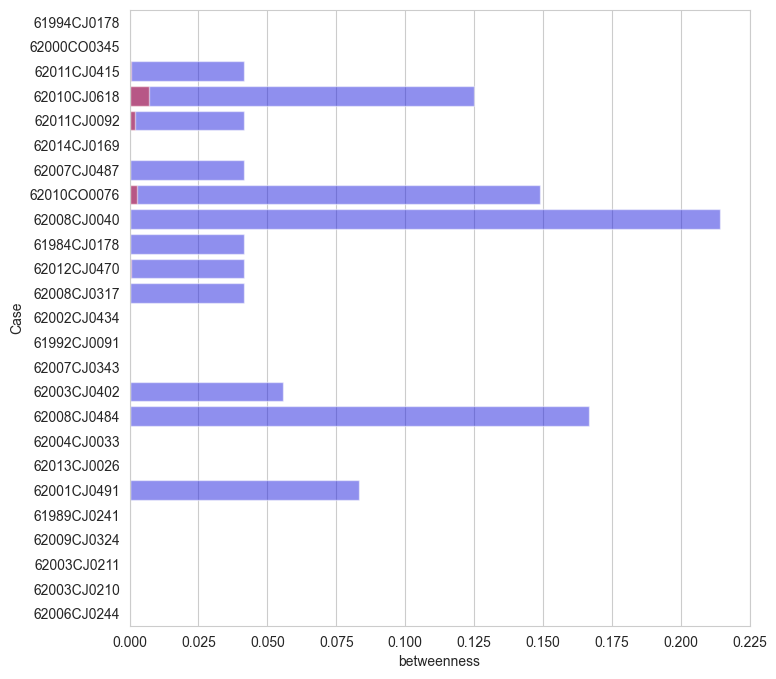

In [165]:
sns.barplot(y = conprot.Case, x = conprot.closeness, color='blue', alpha =0.5)
sns.barplot(y = conprot.Case, x = conprot.betweenness, color='red', alpha = 0.5)

The cases with CELEX numbers xxx are the decisions with the highest betweeenness centrality scores. Removing these decisions, like in the Medici family example, significantly changes the structure of the network.

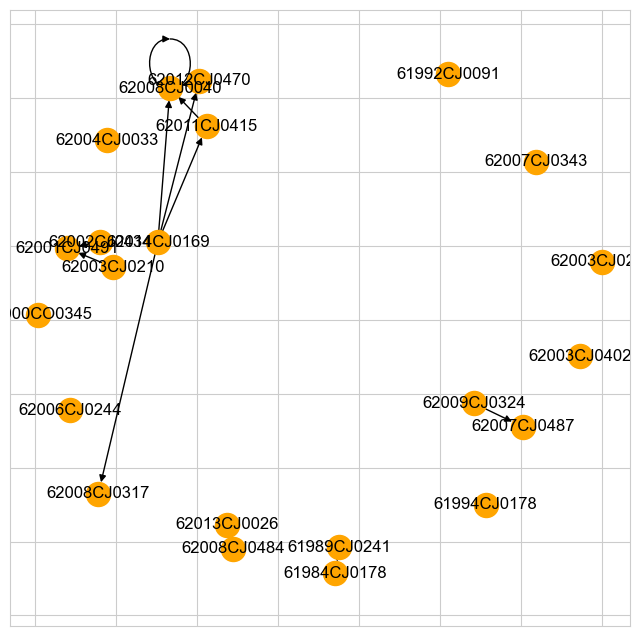

In [166]:
###REDO WHEN RESULTS FROM PREVIOUS ANALYSES ARE FIXED.

g_consprot3 = g_consprot2.subgraph([x for x in g_consprot2.nodes if not x=="62010CJ0618"])
g_consprot3 = g_consprot3.subgraph([x for x in g_consprot3.nodes if not x=="62010CO0076"])
g_consprot3 = g_consprot3.subgraph([x for x in g_consprot3.nodes if not x=="62011CJ0092"])
pos = nx.spring_layout(g_consprot3, seed =123)
nx.draw_networkx_nodes(g_consprot3, pos=pos, node_color="orange")
nx.draw_networkx_edges(g_consprot3, pos=pos)
nx.draw_networkx_labels(g_consprot3, pos=pos);

How can betweenness centrality be explained in more mathematical terms? Betweenness centrality focuses on the number of shortest paths that pass through a node v. First take any pair of nodes s, t. We can obtain the length of all the shortest paths between s and t using a shortest path function that we here call 'spath'.

$$ spath(s, t) $$

We can also get the length of all the shortest paths between s and t that pass through our node of interest, v.

$$ spaths(s, t \mid v) $$ 
(The bar there just says "on condition that they pass through v".)

Subsequently we can calculate the proportion or ratio of shortest paths that pass through v compared to the total number of shortest paths:

$$ \frac{spaths(s, t \mid v)}{spath(s, t)} $$

This will do it for a pair of nodes s, t. But we need to do this for every pair of nodes s, t, and sum the results:

$$ \sum_{s,t \in V} \frac{spaths(s, t \mid v)}{spath(s, t)} $$
(The $ \Sigma $ is effectively saying, "do this for every pair of nodes s, t in V, adding up the results along the way".)

## 3.6 Hyperlink-Induced Topic Search (HITS)

Degree, in-degree, and out-degree (centrality) take the direct neighbors into consideration. Closeness and betweenness centrality considers indirect relationships by including the distance of a particular node to other nodes in the network. HITS combines both approaches by considering the number of edges of the nodes that are connected to a particular node. The idea here is that it is important to know whether incoming edge come from or go to nodes that have a lot of edges (or not). Hence, the nodes of a directed graph are measured on two attributes: authority & hub. 

* The authority score indicates how frequently a node is cited by nodes that are ‘hubs’. 

* The hub score, in turn, indicates how often a node is cited by nodes that are ‘authorities’. 

Both are mutually reinforcing: a good hub is a node that links to many good authorities, and a good authority is a node that is linked to by many good hubs. The authority score is the sum of the hub scores of all nodes that refer to it, whereas the hub score is the sum of the authority scores of all nodes to which it refers.

When analyzing a network of citations between court decision, nodes with a high hub score represent cases that have many citations to authoritative cases, and nodes with a high authority score represent cases that have many citations from hub cases.

The HITS algorithm will return the hub scores and authorities scores for each node. There is also the option to get the results normalized and without normalization. The print below, where we calculate the scores for the cases in the subgraph of the consumer protection network, shows everything.

In [167]:
results = nx.hits(g_consprot2, normalized=False)
results_n = nx.hits(g_consprot2, normalized=True)
hubs = results[0]
authorities = results[1]
hubs_n = results_n[0]
authorities_n = results_n[1]
df_hits = pd.DataFrame({'nodes':hubs.keys(),
                   'hubs': [np.round(x,2) for x in hubs.values()],
                  'authorities': [np.round(x,2) for x in authorities.values()],
                  'hubs_normalized': [np.round(x,2) for x in hubs_n.values()],
                   "authorities_normalized": [np.round(x,2) for x in authorities_n.values()]})
df_hits

C:\Users\gijs.vandijck\Anaconda3\envs\networkanalysis\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


,nodes,hubs,authorities,hubs_normalized,authorities_normalized
0,61994CJ0178,0.00,0.00,-0.00,-0.00
1,62000CO0345,0.00,0.00,-0.00,-0.00
2,62011CJ0415,1.50,0.15,0.18,0.06
3,62010CJ0618,1.44,0.37,0.18,0.16
4,62011CJ0092,0.00,0.08,0.00,0.03
5,62014CJ0169,1.56,0.00,0.19,-0.00
6,62007CJ0487,0.00,-0.00,-0.00,-0.00
7,62010CO0076,1.04,0.40,0.13,0.17
8,62008CJ0040,0.72,0.72,0.09,0.31
9,61984CJ0178,0.00,0.00,-0.00,0.00


Normalization here means showing each score as the proportion of the total scores, so that each hub score is divided by the sum of hub scores, and each authority score is divided by the sum of authority scores, so for example:

$$ hn = \frac{h}{\Sigma_h} $$  

Like Eigenvector centrality, HITS is an iterative algorithm that can be represented in many ways. Here, we will present one option that uses repeated multiplication on a modified version of the adjacency matrix. For this, let us first get the adjacency matrix of our graph.

In [168]:
Ad = nx.adjacency_matrix(g_consprot2).todense()
Ad

C:\Users\gijs.vandijck\AppData\Local\Temp\ipykernel_1480\1605275432.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ad = nx.adjacency_matrix(g_consprot2).todense()


matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Now we have to scale the adjacency matrix by the transpose of itself. Transposition here just swaps the order of rows and columns. We call this new matrix M.

$$ M = Ad^T \times Ad $$

In numpy code this is represented in this manner:

In [169]:
M = Ad.T@Ad

Now that we have M, we are going to simulate the repeated scaling of a set of initial values by M, just like with did with Eigenvector Centrality. Since we have a 25x25 matrix, we are going to create a vector x with 25 initial values of 0.04.

$$ x = [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04] $$


In [170]:
x = (np.ones(25)/25)
for i in range(0,100):
    x = M@x.reshape(25,1)
    mynorm = np.linalg.norm(x)
    x = x/mynorm
np.round(x,2)

array([[0.  ],
       [0.  ],
       [0.15],
       [0.37],
       [0.08],
       [0.  ],
       [0.  ],
       [0.4 ],
       [0.72],
       [0.  ],
       [0.15],
       [0.15],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.32],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ]])

######THE RESULTS DO NOT COINCIDE. THE NORMALIZED SCORES DO. 

Check that these are the same results as the authority scores not normalized. We will normalize them below. But first let's get the hubs scores. These can be gotten by simply "scaling" the authority scores by the original adjacency matrix.

In [171]:
y = Ad@x
np.round(y, 2)

array([[0.  ],
       [0.  ],
       [1.5 ],
       [1.44],
       [0.  ],
       [1.56],
       [0.  ],
       [1.04],
       [0.72],
       [0.  ],
       [1.12],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.77],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ]])

Here we normalize the results by dividing each value (hubs or authorities) by the total sum of values.

In [172]:
sumx = np.sum(x)
myauth_norm = x/sumx
myauth_norm = np.round(myauth_norm,2)

sumy = np.sum(y)
myhubs_norm = y/sumy
myhubs_norm = np.round(myhubs_norm,2)

Now that we have the normalized results, we can plug them in our results dataframe and compare. This is just what nx gave us.

In [173]:
df_hits['my_hubs_norm'] = myhubs_norm
df_hits['my_auth_norm'] = myauth_norm
df_hits

,nodes,hubs,authorities,hubs_normalized,authorities_normalized,my_hubs_norm,my_auth_norm
0,61994CJ0178,0.00,0.00,-0.00,-0.00,0.00,0.00
1,62000CO0345,0.00,0.00,-0.00,-0.00,0.00,0.00
2,62011CJ0415,1.50,0.15,0.18,0.06,0.18,0.06
3,62010CJ0618,1.44,0.37,0.18,0.16,0.18,0.16
4,62011CJ0092,0.00,0.08,0.00,0.03,0.00,0.03
5,62014CJ0169,1.56,0.00,0.19,-0.00,0.19,0.00
6,62007CJ0487,0.00,-0.00,-0.00,-0.00,0.00,0.00
7,62010CO0076,1.04,0.40,0.13,0.17,0.13,0.17
8,62008CJ0040,0.72,0.72,0.09,0.31,0.09,0.31
9,61984CJ0178,0.00,0.00,-0.00,0.00,0.00,0.00


Now remember that repeated multiplication is connected to eigenvectors, so here we can see that an alternative way to get the same result is to get the eigenvectors corresponding to the largest eigenvalue of M.

In [174]:
vals, vecs = np.linalg.eig(M)

###### DON'T THINK SO IN THIS NETWORK. NEED TO ADJUST BELOW.

The largest eigenvalue is in position 0.

In [175]:
vals

array([ 1.01987859e+01,  3.70921223e+00,  2.94483391e+00,  1.51596990e+00,
        4.84557371e-01,  1.46640692e-01, -1.59531501e-16, -2.46519033e-32,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

And this is just our result for the authority score not normalized. If we multiply the adjacency matrix for this we can get the hubs score and then normalize to end up in the same place. 



In [176]:
vecs[:,0]

matrix([[ 0.        ],
        [ 0.        ],
        [-0.15260398],
        [-0.37475129],
        [-0.07540817],
        [ 0.        ],
        [ 0.        ],
        [-0.39799766],
        [-0.72381211],
        [ 0.        ],
        [-0.15260398],
        [-0.15260398],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.31891229],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]])

The advantages and disadvantages of this or that procedure for getting the results will not be discussed here.

# 4_Community_Detection

The detection of communities can bring structure in the network, making the results easier to interpret. In a court decisions citation network, for instance, one rather inspects 35 communities than 2,500 nodes. Ideally, the communities are substantively meaningful, meaning that the court decisions within a community have properties in common that they do not, or to a lesser extent, share with court decisions outside of that community. For instance, court decisions in a specific community in a given network might share that they are about causality, or about traffic accidents, whereas other communities might be about other legal or factual topics. This way, community detection can reveal groups of decisions that concern certain topics, facts, or are otherwise related based on citation patterns.

Community detection methods exist that automatically assign nodes to communities. Below, we give insight into how community detection works. 

## 4.1  Spectral Clustering

In the karate club example, we were interested in whether we could identify two groups: One that follows the president, and one that follows the trainer. One way to cluster networks into communities is to use KMeans on something that represents the action that is going on in the network. The K in KMeans stands for the number of clusters one wants to obtain. We start with two communities. 

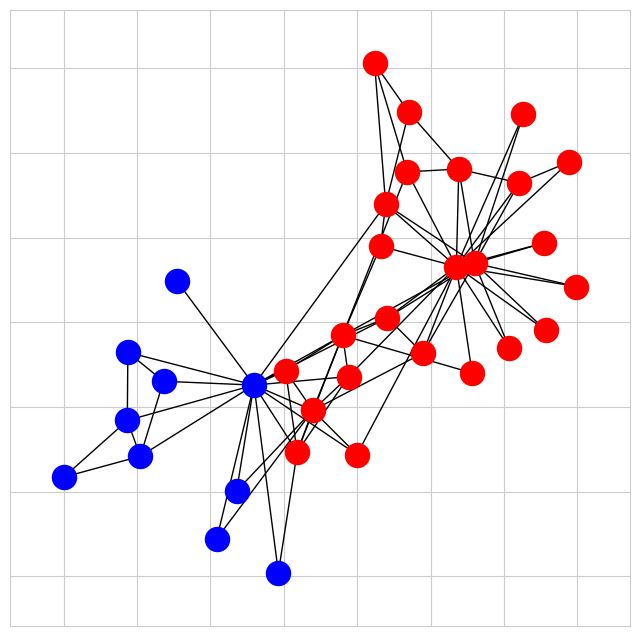

In [177]:
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=[0,  4,  5,  6, 10, 11, 12, 16, 17, 21], node_color="blue")
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist=[1,  2,  3,  7,  8,  9, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25, 26,27, 28, 29, 30, 31, 32, 33], node_color="red")
nx.draw_networkx_edges(g_karate, pos=pos)

How to obtain these two clusters with KMeans clustering? This can be done if the network is represented in mathematical form. The steps are easy to follow even if their inner workings are mysterious. 

Let us begin by introducing two matrices that encode information of the network: the degree matrix and the adjacency matrix. The degree matrix records the degree (number of edges) of every node. It does so in the diagonal. 

Below we have, let's say, four court decisions. The first one has a degree of two, the second and third a degree of 3, and the fourth a degree of 2.

$$ D = \pmatrix{
2 & 0 & 0 & 0 \\ 
0 & 3 & 0 & 0 \\ 
0 & 0 & 3 & 0 \\ 
0 & 0 & 0 & 2 \\ 
} $$

The adjacency matrix, by contrast, records the edges between the nodes. So a 1 here means a citation (from one case to another) and a 0 none (this was explained in more detail in section 3.3). 

$$ A = \pmatrix{
0 & 1 & 1 & 0 \\ 
1 & 0 & 1 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
} $$

Using these two matrices we can find the Graph Laplacian matrix by simply subtracting the adjacency matrix from the degree matrix, so 

$$ L = D-A $$

Substraction of matrices is basic arithmetic, it just means elementwise substractions, so we do (for the first row:) 2-0, 0-1, 0-1, 0-0, and so forth until we get:

$$ L = \pmatrix{
2 & -1 & -1 & 0 \\ 
-1 & 3 & -1 & -1 \\ 
-1 & -1 & 3 & -1 \\ 
0 & -1 & -1 & 2 \\ 
} $$

Naturally the arithmetic involved in this will be practically impossible for humans on any matrix of reasonable size. Software can just give you the Laplacian matrix of a graph on command.

Below we show part of such matrix for the karate club example. As you can see, even for a small graph the matrix is unwieldy.

In [178]:
laplacian_karate = nx.laplacian_matrix(g_karate)
pd.DataFrame(laplacian_karate.todense()).head()

<class 'networkx.utils.decorators.argmap'> compilation 44:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,42,-4,-5,-3,-3,-3,-3,-2,-2,0,...,0,0,0,0,0,0,0,-2,0,0
1,-4,29,-6,-3,0,0,0,-4,0,0,...,0,0,0,0,0,0,-2,0,0,0
2,-5,-6,33,-3,0,0,0,-4,-5,-1,...,0,0,0,-2,-2,0,0,0,-2,0
3,-3,-3,-3,18,0,0,0,-3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-3,0,0,0,8,0,-2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The next step is to find the eigenvector associated with the smallest non-zero eigenvalues. As a rule of thumb, how many eigenvectors you want depends on how many clusters you want. If you want two clusters, you need to look for the smallest eigenvector. If you want three clusters, you select the two smallest, and so on.

Let us print a list of eigenvalues (obtained with Numpy, a package available in Python). As you will see the smallest value is 0.469 at position 10 (note that we start counting at 0, not 1).

In [179]:
# this get us the values and the vectors
vals, vecs = np.linalg.eig(laplacian_karate.todense())
# here we extract the values
print(np.round(vals,3))

###VALUES DO NOT CORRESPOND WITH TEXT ABOVE.

[52.065 45.991 41.833 37.993 29.688 25.556 22.785 21.359 19.324 17.034
 14.889 14.381 12.075 11.874  0.    10.222 10.011  9.181  1.187  6.978
  6.446  5.595  2.394  5.169  4.978  4.697  4.545  4.162  3.706  3.801
  2.932  2.968  3.121  3.061]


We can get the eigenvectors in position 10, that is, those associated with the smallest non-zero eigenvalue. Note that there are 34 of them, one for each node in the Karate club network example.

In [180]:
X = vecs[:,10]
X

matrix([[-5.59951382e-02],
        [-1.00099312e-01],
        [-4.49172749e-02],
        [-1.73854630e-01],
        [ 1.20348712e-02],
        [ 2.65637486e-02],
        [ 4.33698227e-02],
        [ 6.42611713e-01],
        [-5.59739413e-02],
        [ 9.40364844e-03],
        [-5.52448489e-04],
        [ 1.41299872e-02],
        [ 5.30426635e-02],
        [-6.74954523e-01],
        [ 1.08553645e-02],
        [ 2.20854579e-02],
        [-2.36034134e-02],
        [ 1.78397820e-02],
        [ 6.76003355e-03],
        [ 3.49522807e-02],
        [ 6.78736509e-03],
        [ 2.86712354e-02],
        [ 1.28729345e-02],
        [ 3.43506628e-02],
        [-6.57029751e-02],
        [ 4.57079740e-02],
        [ 7.01414301e-02],
        [ 1.50006335e-01],
        [ 2.02333162e-02],
        [-1.39144667e-01],
        [ 1.30871558e-01],
        [-1.15660477e-02],
        [-1.34884606e-02],
        [-3.34393532e-02]])

Having this, we can cluster them using KMeans. In our case, we select two clusters.

In [181]:
from sklearn.cluster import KMeans
km = KMeans(2)
results = km.fit_predict(X)
for i in range(0,2):
    print(f"nodes for cluster {i}", np.where(results == i),"\n")

nodes for cluster 0 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64),) 

nodes for cluster 1 (array([13], dtype=int64),) 



C:\Users\gijs.vandijck\Anaconda3\envs\networkanalysis\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


We can also select a different number of clusters. For instance, three clusters. Here we will need the eigenvectors associated with the two smallest non-zero eigenvectors. These are 0.469 at position 10, and 1.125 at position 15.

In [182]:
X = vecs[:,[10,15]]
X

matrix([[-5.59951382e-02,  1.00461530e-02],
        [-1.00099312e-01, -1.02968357e-02],
        [-4.49172749e-02, -6.52870012e-03],
        [-1.73854630e-01, -1.99282249e-02],
        [ 1.20348712e-02,  7.07544827e-01],
        [ 2.65637486e-02, -2.43666267e-01],
        [ 4.33698227e-02,  1.52005166e-01],
        [ 6.42611713e-01, -3.85123747e-02],
        [-5.59739413e-02,  1.88532752e-02],
        [ 9.40364844e-03,  5.98685634e-04],
        [-5.52448489e-04, -6.35394106e-01],
        [ 1.41299872e-02, -4.17325286e-03],
        [ 5.30426635e-02,  7.99421451e-03],
        [-6.74954523e-01, -1.43709320e-02],
        [ 1.08553645e-02,  1.88041901e-04],
        [ 2.20854579e-02, -3.79656657e-04],
        [-2.36034134e-02,  6.51339103e-02],
        [ 1.78397820e-02, -1.35637242e-03],
        [ 6.76003355e-03, -1.58237549e-04],
        [ 3.49522807e-02, -1.15129765e-04],
        [ 6.78736509e-03,  3.35026314e-04],
        [ 2.86712354e-02,  8.05818570e-05],
        [ 1.28729345e-02, -2.265

In [183]:
from sklearn.cluster import KMeans
km = KMeans(3)
results = km.fit_predict(X)
for i in range(0,3):
    print(f"nodes of cluster {i}", np.where(results == i),"\n")

nodes of cluster 0 (array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64),) 

nodes of cluster 1 (array([4], dtype=int64),) 

nodes of cluster 2 (array([13], dtype=int64),) 



C:\Users\gijs.vandijck\Anaconda3\envs\networkanalysis\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


And here we can see the results of the clustering.

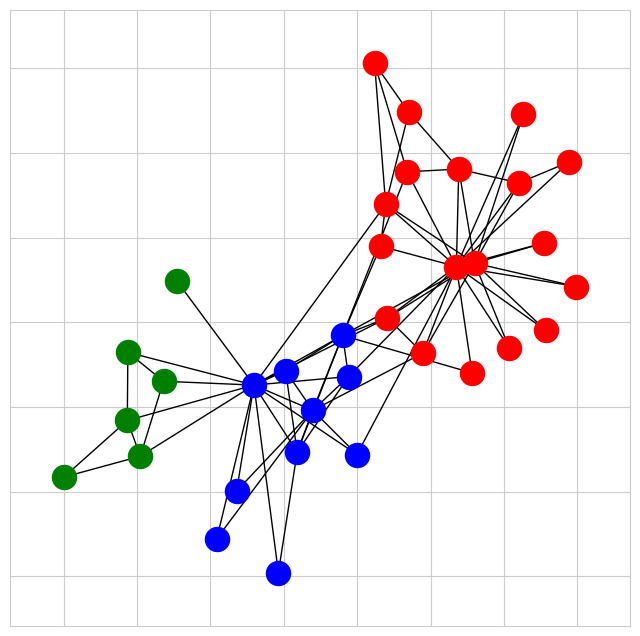

In [184]:
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=[0,  1,  2,  3,  7, 12, 13, 17, 19, 21], node_color="blue")
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist=[8,  9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], node_color="red")
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist=[4,  5,  6, 10, 11, 16], node_color="green")

nx.draw_networkx_edges(g_karate, pos=pos)

## 4.2 Louvain Communities

The Louvain method for community detection is an algorithm that finds communities by using the concept of modularity gain. 

To get into this, we first have to understand the concept of modularity.

### A. Modularity

Modularity in essence does two things:
1. It compares the edges of nodes in a certain community to the edges the nodes have to nodes outside of the community. Court decisions on contract law are more likely to cite one another (edges within the community) than to cite court decisions on human rights (edges outside of the community). The edges within the community can be compared to the edges outside of the community. The higher the number of edges within the community relative to the edges with nodes outside of the community, the higher the modularity.
2. It takes into consideration the number of edges in the network. The higher the number of edges in the network, the less important the difference becomes between the edges within the community and the edges to nodes outside of the community. This prevents small yet dense communities obtaining the highest modularity score and makes it more likely that larger denser communities (with more edges) will receive a high modularity score.

Both considerations are reflected in the formula for modularity, For ease of presentation, we will only consider modularity for undirected networks.

The formula for modularity can be presented in a variety of ways and there are advantages to each form or presentation. Here are two formulas:

$$ Q = \frac{1}{2m}\sum_{c=1}^{n} \left[ \Sigma A_c - \gamma\frac{\Sigma D_c^2}{2m} \right] $$


$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$

(These formulas have been adapted from the documentation to make the notation easier to follow, especially for an attempt to put them in practice by hand.)

For our discussion we will focus on the second formula, because it most clearly shows a difference between two ratios. The representation we choose here provides the most insight into what modularity does. 

* $ \Sigma A_c $ is the sum of the adjacency matrix of the community only (no edges to nodes outside of the community) .

* $ m $ is the total number of edges of the network.

* $\Sigma D_c$ is the degree of the nodes of the community, taking into consideration their edges to nodes outside of the community.

* $\gamma$ is a dampening parameter, that for our purposes can be ignored if set to 1. Making this number smaller will make it easier to find communities, and making it larger makes communities harder to find. (!!CHECK!!)

We observe a difference between fractions. That is to say, a difference between proportions.

* $ \frac{\Sigma A_c}{2m} $ represents the proportion of purely intra-community edges for a given community to the total number of edges. The division by 2 considers the fact that the adjacency matrix will count two for every edge.

* $ \left( \frac{\Sigma D_c}{2m} \right) ^2 $ represents the proportion of the edges that a community has to nodes within and outside of itself to the total number of edges in the network.

The logic of this is that if the left hand side of the difference is greater than the right hand side of the difference one will get a positive number. And the larger the difference, the tighter a community is, the larger the number. 

* The $ \Sigma $ is a summation notation that states that the difference between fractions will be repeated for every hypothesized community and added up. The higher the ultimate summation, the better the community partition is.

We can operationalize the formula "by hand" on the graph of Florentine families hypothesizing that the families Castellani, Peruzzi and Strozzi form a community vis-a-vis the rest of the other families. A quick look at the graphs suggest that this is a reasonable grouping.

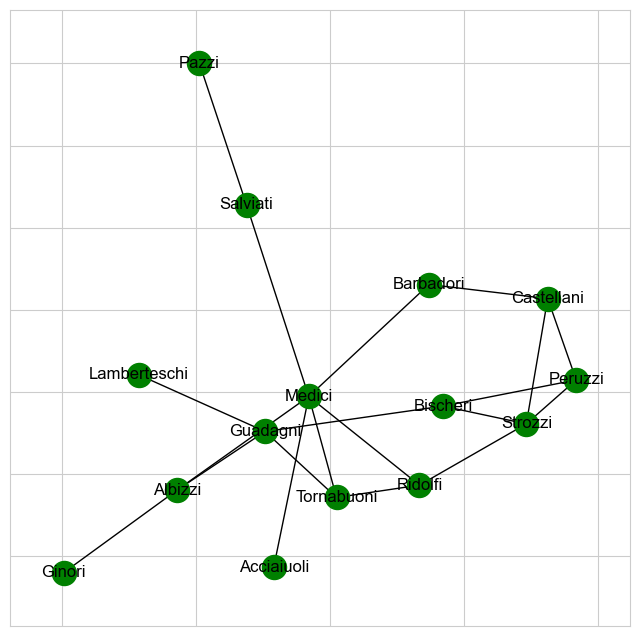

In [185]:
pos = nx.spring_layout(g_florentine, seed =123)
nx.draw_networkx_nodes(g_florentine, pos=pos, node_color="green")
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

First let us save two lists with the names of the nodes that we want to use as hypothesized communities. Castellani, Peruzzi and Strozzi in one list, the rest on the other.

In [186]:
fl_CPS = ['Castellani','Peruzzi','Strozzi']
fl_other= ['Acciaiuoli', 'Medici', 'Barbadori', 'Ridolfi', 'Tornabuoni', 'Albizzi', 'Salviati', 'Pazzi', 'Bischeri', 'Guadagni', 'Ginori', 'Lamberteschi']

Since m is just the number of edges we can obtain the number in this manner.

In [187]:
m = len(g_florentine.edges)
m

20

For $\Sigma A_c $ we need to get the adjacency matrix of just the nodes within the community. This means we need to sever the connection of the community with other nodes. We can get this with the subgraph function.

In [188]:
sub_fl_CPS = g_florentine.subgraph(fl_CPS)
sub_fl_other = g_florentine.subgraph(fl_other)

Now we can get the adjacency matrix of the subgraphs like this...

In [189]:
nx.adjacency_matrix(sub_fl_CPS).todense()

C:\Users\gijs.vandijck\AppData\Local\Temp\ipykernel_1480\1760126056.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(sub_fl_CPS).todense()


matrix([[0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]], dtype=int32)

Numpy can sum all the values of such matrices with a call to np.sum.

In [190]:
SA_cps = np.sum(nx.adjacency_matrix(sub_fl_CPS).todense())
SA_other = np.sum(nx.adjacency_matrix(sub_fl_other).todense())
print(f"the value of SigmaA_c for the CPS community is {SA_cps} and for the other is {SA_other}")

the value of SigmaA_c for the CPS community is 6 and for the other is 26


C:\Users\gijs.vandijck\AppData\Local\Temp\ipykernel_1480\3820810424.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  SA_cps = np.sum(nx.adjacency_matrix(sub_fl_CPS).todense())
C:\Users\gijs.vandijck\AppData\Local\Temp\ipykernel_1480\3820810424.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  SA_other = np.sum(nx.adjacency_matrix(sub_fl_other).todense())


This gets us all we need for the left hand side of the difference.

Now we move to work on the right side of the difference. The value of $ \Sigma D_c $ is the sum of the degree of the nodes that interest us, but not with their values cut off from the network -that is, not as subgraphs- but in their full values connected to the Florentine families network. 

In terms of code it can be slightly tricky to unpack these values. Below we use a np.sum over a list comprehension that produces the degree scores of only the nodes we need.

In [191]:
SD_cps = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_CPS))])

SD_other = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_other))])

print(f"the value of SigmaD_c for the CPS community is {SD_cps} and for the other is {SD_other}")

the value of SigmaD_c for the CPS community is 10 and for the other is 30


Now we are ready to fill in the blanks. Remember the formula is:

$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$

So for the first community we have

$$ CPS =\left[ \frac{6}{40} - \gamma\left( \frac{10}{40} \right) ^2 \right] = 0.875 $$

In [192]:
CPS_result = (SA_cps/(2*m)) - ((SD_cps/(2*m))**2)
CPS_result

0.0875

And for the second 

$$ other = \left[ \frac{26}{40} - \gamma\left( \frac{30}{40} \right) ^2 \right] = 0.875 $$

In [193]:
other_result = (SA_other/(2*m)) - ((SD_other/(2*m))**2)
other_result

0.08750000000000002

And adding them together we get 0.175

In [194]:
CPS_result + other_result

0.17500000000000002

 Which is the same as the official result.

Thus the following partition has the positive modularity score of 0.175.

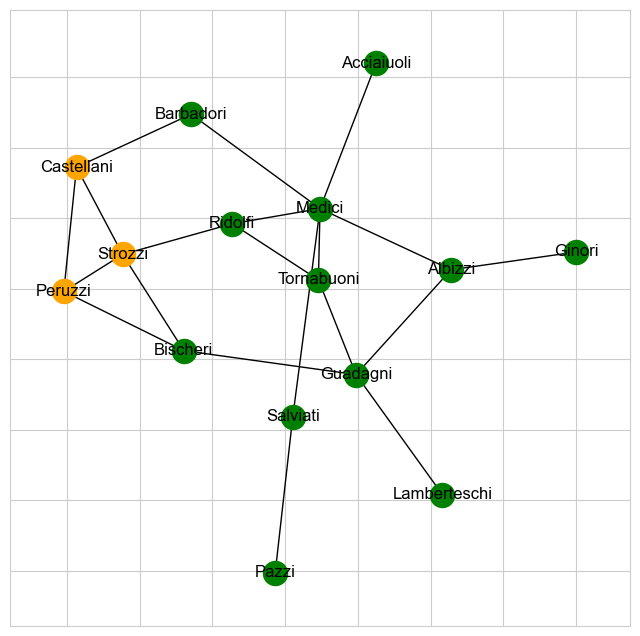

In [195]:
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_CPS, node_color='orange')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_other, node_color='green')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

### B. Louvain Communities

What Louvain community detection does, is to try to find the distribution of communities that will give the highest modularity score, using a sort of cumulative random search.

1. It will asume every node is a community and score the modularity.
2. It will assign every node to a community with one of its neighbors and score the modularity of the result.
3. It will keep the assignment that gives the highest modularity score.
4. The resulting communities will be treated as nodes.
5. Step 1 is repeated.

This process keeps going until there is no more modularity gain.

We can quickly try to run the Louvain communities algorithm to find the best partition of the Florentine families network that we used earlier to discuss modularity.
It turns out the best split is in four communities. Compared to our intuitive results presented above, we can see that Castellani, Peruzzi and Strozzi did deserve to go together, but that Bischeri should have been also part their team.

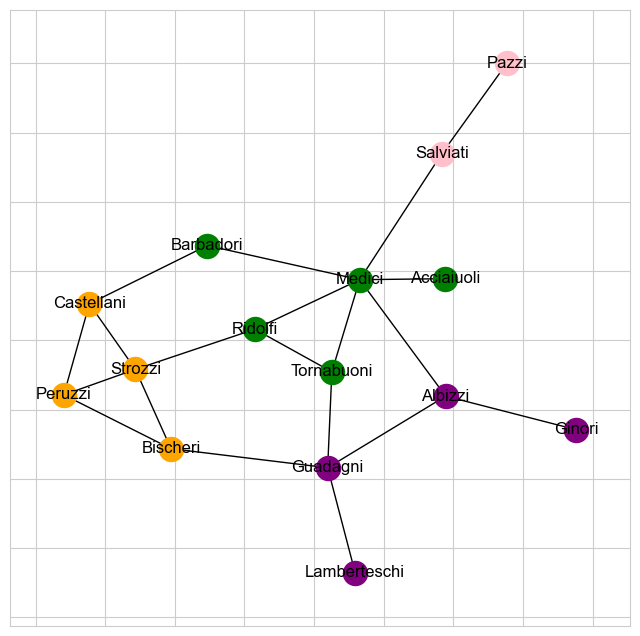

In [197]:
result = nx.algorithms.community.louvain_communities(g_florentine)
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[0], node_color='orange')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[1], node_color='green')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[2], node_color='purple')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[3], node_color='pink')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

Now let us calculate the modularity score for the Louvain-detected communities. We can see that at 0.3975 it is quite a bit higher than our intuitive partition.

In [198]:
nx.algorithms.community.modularity(g_florentine, result)

0.3975

We now try to approximate this by hand. Let us see how far we can get. We will use a smaller graph, the kite, to make our life easier. There are key differences between what we are doing and the actual Louvain Communities algorithm. However, this will be enough for us to get an idea of what is going on.

The question is how to best partition the kite in terms of modularity.

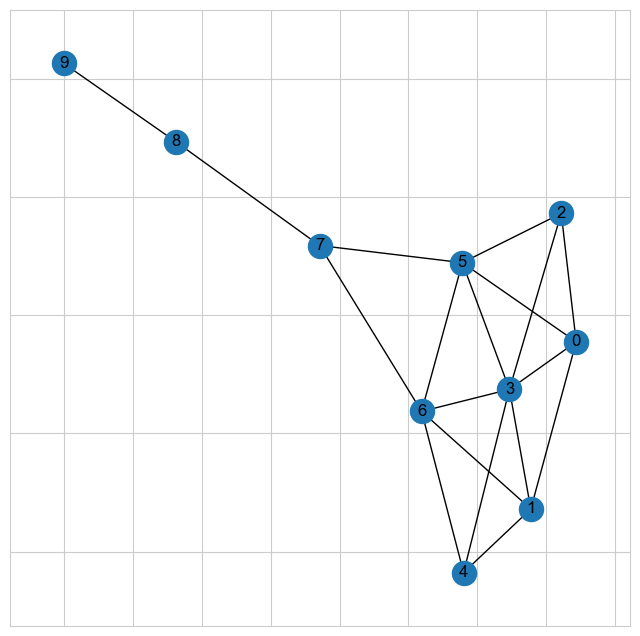

In [199]:
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos)
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

Doing a pseudo-Louvain process, We begin by assigning each node in the kite graph to its own community. Since this is a very bad partition, it makes sense that we get a negative modularity score.

In [200]:
nx.algorithms.community.modularity(g_kite, [[x] for x in range(0,10)])

-0.11574074074074076

Now we will assign each node, to one of its neighbors, and obtain the modularity score.

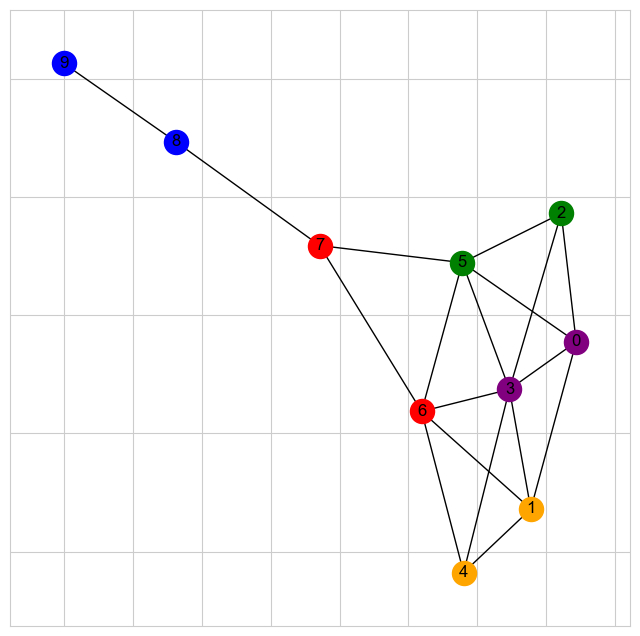

In [201]:
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[7,6], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,2], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[3,0], node_color='purple')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [202]:
nx.algorithms.community.modularity(g_kite, [[9,8], [7,6], [5,2],[4,1],[3,0]])

0.057098765432098755

Then we could keep assigning nodes and see an increase.

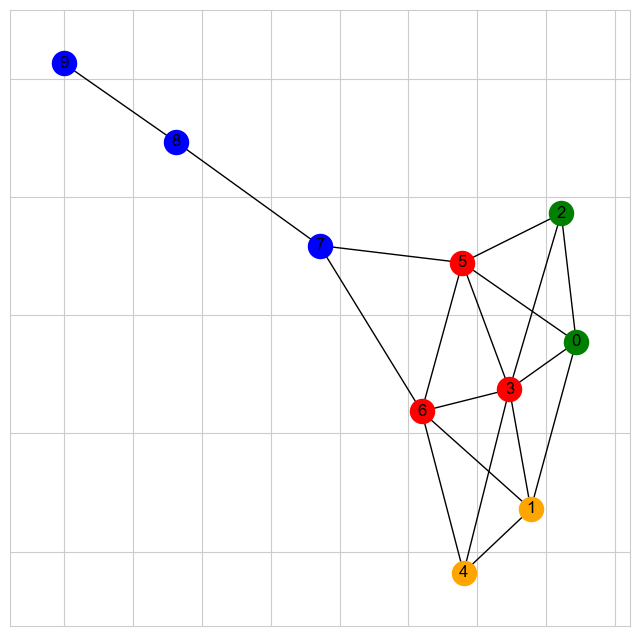

In [203]:
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[6,5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [204]:
nx.algorithms.community.modularity(g_kite, [[9,8,7], [6,5,3], [2,0],[4,1]])

0.08796296296296295

But not every reassignment is going to be an increase. If we extend the first cluster, we will get a decrease in modularity.

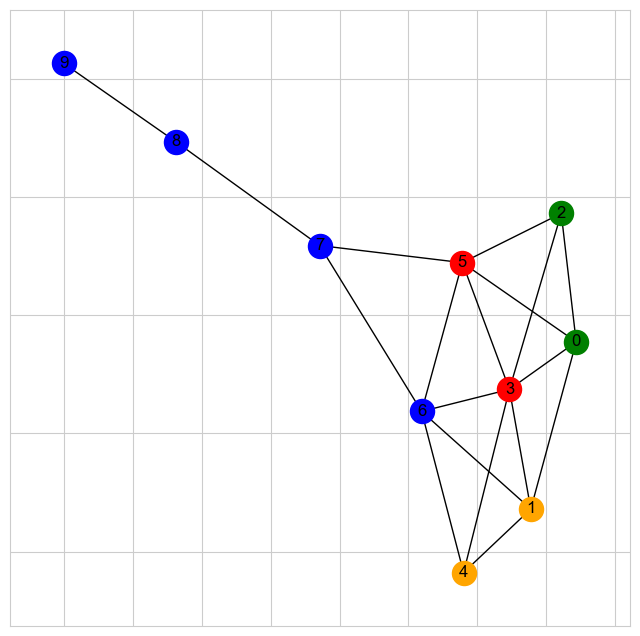

In [205]:
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7, 6], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [206]:
nx.algorithms.community.modularity(g_kite, [[9,8,7, 6], [5,3], [2,0],[4,1]])

0.07098765432098764

Our pseudo-Louvain algorithm would therefore stop short of that last assignment. The real Louvain method would do this in an mechanical, incremental fashion until the communities with very good modularity scores are found. The algorithm has elements of randomness, so it is not guaranteed to achieve the best result, or the same result every time it is run.

A difference of note is that instead of incrementally linking up the nodes of the kite, what are the communities at the first level will be turned into nodes at the second level. (!!add photo from louvain to leuven article!!). 

What this means in practice, is that unlike what we are doing, the algorithm does not focus on modularity per se, but on modularity gain. That is, it focuses on the difference in modularity between one partitioning and another. It does not really look for the highest modularity value, but instead keeps going while it finds positive modularity gain, or until modularity gains are so small that they fall below a specified margin.

Happily, the formula for modularity gain is not so different from that of modularity

$$ \Delta Q = \left[ \frac{\Sigma A_c + K_{in}}{2m} - \frac{\Sigma D_c + K_{in}}{2m} \right] - \left[\frac{\Sigma A_c}{2m}-\frac{\Sigma D_c}{2m} - \frac{K_in}{2m}  \right]   $$

In fact it is the ratio of two modulary scores. One (the left brackets) is the score with the node K inserted into it and the the other (the right bracket) is the score with the node K removed from it. It is added on the left and removed on the right to represent the delta, or the difference in modularity, when one community gains a node and another one loses it.

With our pseudo-Louvain approach we did not did do the best possible combination, but with the real Louvain communities algorithm we can see what the better partition would be:

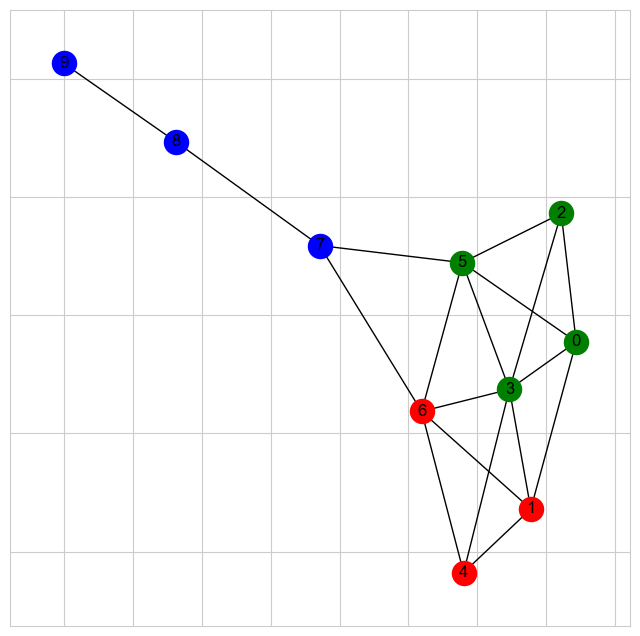

In [207]:
pos = nx.spring_layout(g_kite, seed=123)
result = nx.algorithms.community.louvain_communities(g_kite)
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[0], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[1], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[2], node_color='blue')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

We can do the same for the subgraph of the CJEU case law example. We first calculate the number of communities:

In [208]:
communities = sorted(nx.algorithms.community.greedy_modularity_communities(g_consprot2), key=len, reverse=True)
print(f"The network has {len(communities)} communities.")

The network has 13 communities.


We subsequently plot assign each node to a community and visualize the communities in the network.

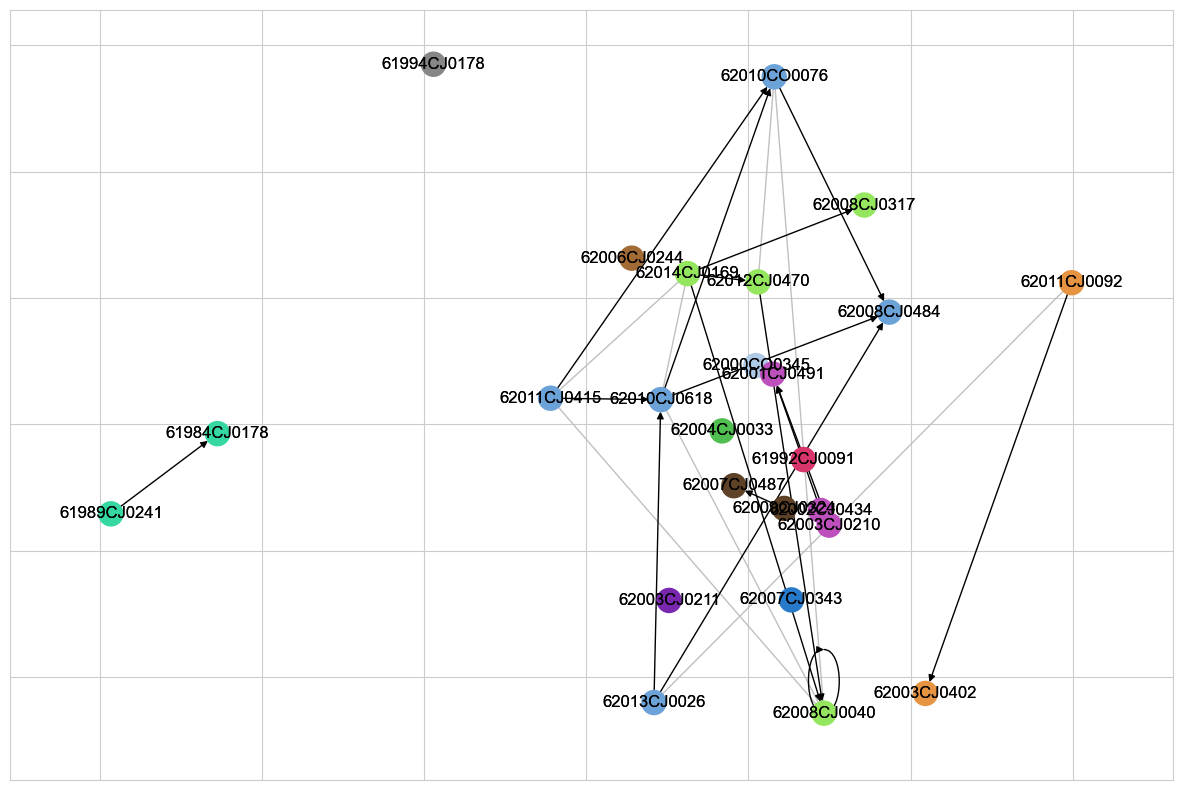

In [214]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

# Set node and edge communities
set_node_community(g_consprot2, communities)
set_edge_community(g_consprot2)
node_color = [get_color(g_consprot2.nodes[v]['community']) for v in g_consprot2.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

# Set node and edge communities
set_node_community(g_consprot2, communities)
set_edge_community(g_consprot2)
node_color = [get_color(g_consprot2.nodes[v]['community']) for v in g_consprot2.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

g_consprot2_pos = nx.spring_layout(g_consprot)
plt.rcParams.update({'figure.figsize': (15, 10)})
# Draw external edges
nx.draw_networkx(
    g_consprot2,
    pos=g_consprot2_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")
# Draw nodes and internal edges
nx.draw_networkx(
    g_consprot2,
    pos=g_consprot2_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)
plt.show()

# 5_Data_Collection_and_Data_Preparation

The previous chapters did not yet address a crucial prerequisite for the application of network analysis: ensuring that the data is suitable for conducting network analysis. This chapter addresses this aspect.

The first step is to obtain usable data, and turning the data *into* the network. Obtaining the data may be done by hand, electronically, or both. This data must be put in a format suitable to be read and processed by network analysis software. In this respect, we will discuss how data might be extracted through qualitative coding or data mining. We will focus on the ways you can structure the data in a format that is readable by the software.
What you will see here are just examples, as the researcher will need to develop a strategy that fits his / her own problem.

## 5.1 The Research Question Offers Guidance

What data is required, first and foremost depends on the aim of the research and the questions that you are asking. These determine the design and the scope of the research and therefore affect the boundaries of the network that you are investigating. The research questions will focus on certain relations (edges), offering guidance as to what elements (nodes) or variables to include in the network and which in turn determines the data that you need to obtain. For instance, if we want to conduct a network analysis of an organized crime syndicate, a number of questions could be relevant. We can ask which actors are related to each other and who is the most important actor given those relations? Moreover, we could examine the types of criminal offences they were involved in, when, and with whom? This helps us to answer the broader question how criminal networks and activities develop over time. We could also include metadata about gender, age or nationality of the actor and locus delicti of the crimes, etc. to shed even more light on the characteristics of the offender and the offences. 

To develop such a network analysis of an organized crime syndicate you can rely on information that can be retrieved from various sources, such as newspaper articles that report on the activities of the network, or more elaborate journalistic and scholarly investigations that address the criminal network and its characteristics more in depth. Or maybe you can even get access to police or court files that shed light on the criminal activities, their organization and the question to what extent these activities amount to criminal offences. 

Our first question concerns a straightforward actor network, which means that we will need to analyse and code our journalistic, scholarly, police or court data for actors and their relations. To address our second question, we will need to go through our data and we need to code the offences perpetrated, the date and location, and the names of the actors involved, etc.

## 5.2 Data Collection and Qualitative Coding

To obtain the relevant data you will need to look for data sources, which can include (online) communities, events, actors, archives, etc. To extract relevant data from these sources, researchers often rely on data collection methods used in the social sciences such as field observations, open or structured interviews, surveys, archival and documentation research, etc. The collected data might already be suitable for network analysis, because the data is for instance numerical, which can be the case when doing surveys. However, the data gathered will often probably be qualitative in nature. It will concern written documentation, archival records, interview transcripts, photographs, video footage, field study reports. memo’s etc. In order for such qualitative data to be used, it needs to be formatted into data that can be used in network analysis. This can be done manually through qualitative coding or annotation. This involves the process of defining / labelling the data according to key themes. These categories can be distilled inductively ‘in vivo’ from the data itself or the categories can be taken from relevant theoretical and conceptual frameworks. 

One may examine corporate reports and interviews, and find evidence of partnership relations between corporations. Some of this evidence may be formal statements of partnership. Other evidence may be testiominal evidence to the effect that "we always buy equipment from Nissan". Regarding the second example, we may rely on attitudes expressed in formal written exchanges or in interviews with diplomats. At any rate this information will be qualitative, and thus the researcher will need to judge whether evidence such as "we always buy equipment from Nissan" is sufficient grounds to say that there is a collaboration, and "code" it as such, or not. Or, alternatively, the researcher will want to "weigh" the strength of the evidence, the strength of collaboration, or both, leading to networks with weighted edges. This process will almost always involve value judgments on the part of the researcher. One of the ways that these value judgments can be rendered more objective is through inter-coder reliability. That means that more than one researcher will code (for example, a team of students) and then findings will be weighted down by the degree of disagreement there is between coders.

Qualitative coding thus refers to the process of extracting categorized information from qualitative data sources. Note that this "coding" does not have anything to do with "programming". Coding here means "encoding" the qualitative information into headings or categories that can later be counted and related to each other, for example through networks. Software such as NVivo or Atlas.ti can help you to archive and manage your data and also assist in manual qualitative coding. 

Instead of or in addition to manual coding, qualitative data can, if this is appropriate, be automatically processed and parsed into a meaningful format using a variety of tools. For example, for qualitative text data, methods such as Regular Expressions or Natural Language Processing (NLP) can be used to "mine" qualitative sources, without doing qualitative coding. A relevant example is a network of document similarity. Imagine one starts with a corpus of legally relevant documents, for example a corpus of stakeholder contributions to a regulation. NLP software can produce a similarity score for every pair of such documents. The documents can then be put into a network, with links for documents with high similarity. This can be used to see which were the central or paradigmatic contributions to the negotiation process.

It should, however, not be concluded that this type of data mining is free of value judgments. For example, one may need to decide on the similarity threshold. At what degree of similarity is a line drawn between two documents? 0.7? 0.8? 0.9? Different thresholds will lead to different results (naturally one can also do away with the thresholds and just get the similarity as a weigth, but that would also be a research decision needing justification).

## 5.3 Data Representation

Let us assume that one way or another, we have settled on a strategy to obtain the data we need. But this data needs to be recorded in a way that Network Software can read it. There are three main options for doing this. We will demonstrate how to represent graph data as an adjacency matrix, in tabular/CSV format, and in JSON format. SEPERATE SECTIONS ON CSV AND JASON NEED TO BE ADDED>

Since networks capture relations, what qualitative coding practices must do is classify relations between subjects of study. Looking back at Chapter 1, we can see that this can be between subjects of the same type, or between subjects of different types, in the case of bipartite networks. For an example of the first scenario, consider research trying to identify which big corporations work together in a particular country. An example of the second scenario concerns research trying to establish which states have strong ties to a particular international organization, such as the WTO or the UN.

Such networks are collections of nodes that are connected by edges. The most basic way to conceptualize such a network is using a matrix encompassing the relational ties between the nodes. As shown in previous chapters, such an adjacency matrix is an array or list of data that numerically organizes / indexes the data in rows and columns to capture the relationships. The simplest and most common matrix is the binary matrix that numerically indicates whether a relationship or connection exists or not between the nodes. If a tie is present, a one is entered in a cell; if there is no tie, a zero is entered. An adjacency matrix is a $ n \times n $ matrix that relates the entities in the rows, to the entities in the columns. Because every entity is related to every other entity, the matrix will always be a square one, it will always have the same number of rows and columns. This is in fact implied in the notation $ n \times n $; the same letter is used, so if n = 5, the matrix is 5 x 5, if n = 10 it is 10 x 10, etc., as opposed to an $ m \times n $ matrix where it can be the case that m = 5, and n = 4, or something similar. 

Every "1" in the adjacency matrix will show the presence of a particular relationship, while every "0" will note its absence. A $ 4 \times 4 $ adjacency matrix might look like this.

$$ M = \pmatrix{
0 & 1 & 1 & 0 \\ 
1 & 0 & 1 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
} $$


We can use the adjacency matrix to enter and represent the data regarding the actors involved in the criminal network discussed before. Naturally the easiest way to get data into this structure is through a spreadsheet program. For instance, from our information it becomes clear that 14 individuals show up in the data that we can relate to each other. The relationships can be put in a data frame or matric as shown below. A DataFrame is a generic name for a data strucutre that has columns for variables and rows for observations, allowing, optionally, a first row for variable names. Any spreadsheet program can be used to make a DataFrame. 

![image](images/ch6/spreadsheet_df.png)

Attribute data can be included in the matrix data structure by adding a column related to each attribute variable and the row numbers must coincide with the numbering of the nodes in the relational matrix. This form of data representation means that all the relevant coded thematic/categorical data needs to be ‘translated’ into network terms, to numerical data by assigning numbers.

<img src="images/ch6/attributedata.png" alt="drawing" width="200"/>

In the network visualization you will see the relationships that are logged in the actor/actor matrix combined with the attribute data on gender highlighted in different colours.

<img src="images/ch6/networkviz.png" alt="drawing" width="750"/>

Although the abovementioned matrix is often the starting point for network analysis, an alternative representation can be a so-called edge list, which includes a set of rows in which each row represents a specific tie in the overall network. An edge list consists of sources and targets, which, in a directed graph, coincide with the source nodes and target nodes. In an undirected network with four nodes (A,B,C,D) where Node A is connected to Node B and Node D, where Node B is connected to Node A and Node C, and Node C is connected to Node B, an edge list commonly takes the following shape:

A,B

A,D

B,A

B,C

C,B

(Note that depending on the question one is interested in answering and whether weights should be given to edges, the edges B,A and C,B may be omitted, as they are already in the edges list (i.e. A,B and B,C), at least in undirected networks).

If the network is directed, with Node A referring to Node B, Node A referring to Node D, and Node B referring to Node C, the edges list would look like:

A,B

A,D

B,C

It is commonly possible in network analysis software to have or assign attributes in relation to the nodes. These attributes can be entered and loaded to the software as a node list, where each node ID (which must be similar to the ID used in the edges list) is entered as a separate row and where each attribute gets a new column.


**### where to enter this type of info?** 
It should be noted that this is not the most practical way to record one's data.

Large matrices are hard to work with for humans. Filling in a 20 by 20 matrix by hand is possible but it will be very easy to make mistakes with a 100 by 100 matrix, and at some point it will stop being practical. Just think of much scrolling in Excell will be needed.

Also, these matrices will not have a place to store "metadata", additional information. For example, we could have a lot of information on the Pucci family, such as the name of the head of the family, but we can't fit that into a matrix. For a researcher keeping notes of his qualitaitve work, it will be a hassle to one adjacency matrix for the relations, and another document for the extra data. It would be better to put it all in one place. Moving back and forth between documents naturally increases the risk of human error.

Adjacency matrices remain important because many mathematical manipulations are possible on them, which are not possible in other data formats. However, network analysis software can always convert into a this form, if needed.

## 5.4 Data Format

Once the data is represented in a matrix or list,  it can be formatted into and saved as a specific data type, such as excel, csv, etc. This an important step because the software packages that you can use for network analysis and visualization require specific data formats. We refer you to the documentation of the software that you aim to use to determine in which way the data should be formatted in order to enter it.

# 6_Software

By now, you are almost ready to start conducting legal network analysis yourself. But what software to use? There are essentially three options: 
1. Network analysis software designed for a specific purpose.
2. General-purpose software.
3. Packages in programming software (e.g. Python, R).

## 6.1 Specific Purpose Network Analysis Software

Software has been developed for specific use cases. The advantage of such software is that it is optimized for that use case and that it requires a low level of technical knowledge in order to use the software. The disadvantage is that the platform is designed for a specific purpose, which restricts the freedom in terms of adding or removing functionality.

An example of this type of software concerns Case Law Explorer. This platform has been developed for students, researchers, and practitioners who wish to conduct network analysis on case law. It has automated the process from searching to the calculation of the network statistics and the visualization of the network. A link to the software and to the user guide of the software can be found [here](https://maastrichtlawtech.github.io/case-explorer-ui/#/).

![image](images/ch5/caselawexplorer.png)

## 6.2 General Purpose Network Analysis Software

General purpose software allows applying network analysis to different types of data. The advantage of this type of software is that it can be applied in a number of contexts and for a variety of purposes, whereas the disadvantage is that the functionalities are generic and not tailored to a specific use case.

### A) Gephi

For your convenience, we provide you with a short, hands-on manual for installing Gephi and conducting network analysis with Gephi.

*Preliminaries*. 
You need to [download](https://gephi.org/users/download/) and install Gephi on your laptop. In case of a Java error when opening Gephi, [update Java](https://www.java.com/en/download/). [Check this video](https://www.youtube.com/watch?v=iWQWjx6Ot1E) (Windows) if Gephi still returns a Java error.

*Navigating Gephi*. 
Gephi has three main modes: Data Laboratory, Overview and Preview. 

- Data Laboratory. This is where you can import data and view network data in table format, split into Nodes and Edges. There is a limit on the number of columns this tab will display. Click the light bulb icon on the top right part of the window to choose which columns you want to see.

![image](images/ch5/gephi1.png)

![image](images/ch5/gephi2.png)






- Overview. This is where the magic happens! The Overview tab has four main windows. 
  - *Appearance* (upper left) is used to control node and edge presentation properties. 
  - *Layout* (lower left) is behind the network layout. 
  - *Graph* (centre) shows the sketch of the graph.
  - *Statistics & Filters* (right) is for network analysis and filtering. In the *Statistics* panel, you can calculate various network statistics.
The *Filters* panel supports complex methods to temporarily highlight or hide a part of the network.

![image](images/ch5/gephi3.png)



- Preview. This is where you prepare your final image for export. To see it displayed in the screen click on *Refresh* at the bottom of the panel.

![images](images/ch5/gephi4.png)





*Importing the Data*. Given that you have an edges list (in csv) and possibly a nodes list (in csv), you can follow the following steps in order to import the data:
1. Start Gephi 	
2. From the dialog that appears after	startup, or from the file menu, start a New Project	
3. Go to Data Laboratory 
4. Choose Import Spreadsheet
5. Select your csv file with the nodes 
6. Set the right separator (comma) and set as ‘nodes table’
7. Click Next, then Finish
8. Choose to ‘append to existing workspace’ and click Ok. You should see a neat nodes table now
9. Click Import Spreadsheet again
10. Repeat the	process for the file with edges, but this time	choose	‘edges	table’ as the table	type
11. Click Next, then Finish
12. Choose to ‘append to existing workspace’ and click Ok

*Investigating the network.* The next step is to investigate the network. To get started:
1. Go to the Overview tab. You should now see your network.
2. Run the ForceAtlas 2 layout algorithm in Layout. Note that every layout algorithm can be tweaked by changing parameters. You can play around with the ‘Scaling’ and ‘Prevent overlap’ parameters.

We subsequently calculate the centrality statistics,
3.  Calculate the centralities by running ‘Average degree’ in the Statistics tab. Gephi will show you the degree distributions, but will also add the results to the dataset in Data Laboratory. You may also run ‘Network Diameter’,	which	gives	you various centrality measures based on network diameter, including betweenness centrality. 

change the node size based on the centrality measure of our preference,
4. We visualize the nodes with a higher in-degree by increasing their size. Click on ‘Nodes’ in the Appearance tab, then click the ![images](images/ch5/sizebutton.png) (size) button and choose ‘Ranking’. Select ‘In-Degree’ from the drop-down attribute menu and click Apply. 

and filter the network.
5. You can, for instance, visualize the network of the 50 most central cases (based on in-degree). Go to Data Laboratory and determine the in-degree of the 50th most central case. Then go back to Overview and open the Filters window. Expand the Attributes filter category and select ‘Range’, then double click on ‘In-Degree’. Finally, adjust the indegree range and click Filter. Click Stop to proceed with the next part. 

We can also calculate the community structure,
6. Run ‘Modularity’ in the Statistics tab.

adjust the appearance,
7. Recolor the communities by clicking on ‘Nodes’ in the Appearance tab, then click the ![image.png](images/ch5/colorbutton.png) (color) button and choose ‘Partition’. Select ‘Modularity Class’ from the drop-down attribute menu and click Apply. 

and filter for certain communities.
8. Choose a community and layout again. Open the Filters window. Expand the Partition filter category and double click on ‘Modularity Class’. Finally, select a community to display and click Filter. 

This is only a very basic introduction to Gephi. More information and many videos can be found online (eg [here](https://youtu.be/HJ4Hcq3YX4k)), and we gladly refer to those instructions and materials.

(Note: credits to Constanta Rosca, who co-drafted these instructions for a previously held workshop.)

### B) Other Software Packages

Other software packages that may be used for conducting network analysis include:

*   Pajek
*   UCINET
*   Cytoscape
*   SocNetV

## 6.3 Packages in programming software (e.g. Python, R)

Another option is to use packages such as *NetworkX* or *iGraph* that can be installed and imported in programming languages such as *Python* and *R*. These packages provide a user substantial flexibility as to what the manipulation and calculation of the data. Using the packages does require the knowledge of programming language (or the willingness to learn how to code), and it can be labor-intensive to have to write out all the steps in lines of code.

# Bibliography

Al-Taie, M. Z., & Kadry, S. (2017). Python for graph and network analysis (pp. 1-184). Cham: Springer International Publishing.

Borgatti, S.P., Everett, M.G. and Johnson, J.C. (2013). Analysing social networks. London: Routledge.

Brandes, U. (2005). Network analysis: methodological foundations (Vol. 3418). Springer Science & Business Media.

M Derlen and J Lindholm, ‘Goodbye van Gend en Loos, Hello Bosman? Using Network Analysis to Measure the Importance of Individual CJEU Judgments’ (2014) 20(5) European Law Journal 667-87.

M Derlen and J Lindholm, ‘Is it Good Law? Network Analysis and the CJEU’s Internal Market Jurisprudence’ (2017) 20 Journal of International Economic Law 257-77.

Duijn, P. A., & Klerks, P. P. (2014). Social network analysis applied to criminal networks: recent developments in Dutch law enforcement. Networks and network analysis for defence and security, 121-159.

J Fowler and S Leon, ‘The Authority of Supreme Court Precedent’ (2008) 30 Social Networks 16-39.

Katz, D. M., Gubler, J. R., Zelner, J., & Bommarito, M. J. (2011). Reproduction of Hierarchy-A Social Network Analysis of the American Law Professoriate. J. Legal Educ., 61, 76.

Y. Lupu and E. Voeten, ‘Precedent in International Courts: A Network Analysis of Case Citations by the European Court of Human Rights’ (2011) 42 British Journal of Political Science 413-49.

Newman, M. (2018). Networks. London: Oxford University Press.

PM, K. R., Mohan, A., & Srinivasa, K. G. (2018). Practical Social Network Analysis with Python. Springer International Publishing.

Robins, G. (2015). Doing social network research. London: Routledge.

Scott, John (2000). Social Network Analysis. A Handbook. Sage.

Scott, J. and Carrington, P.J. (2011). The SAGE handbook of Social Network Analysis. London: Sage

Tsvetovat, M., & Kouznetsov, A. (2011). Social Network Analysis for Startups: Finding connections on the social web. O'Reilly.

Wallis, W. D. (2007). A beginner's guide to graph theory. Springer Science & Business Media.

Wasserman, S., & Faust, K. (1994). Social network analysis: Methods and applications. CUP.

Xu, J., & Chen, H. (2005). Criminal network analysis and visualization. Communications of the ACM, 48(6), 100-107.




# Appendices

# 1 Getting Data into NetworkX

The main tool used in this textbook is NetworkX. However, the purpose of the textbook is not to introduce this library, but to explore Network Analysis for law, so some details of how this package works are omitted from the main discussion. However it can be difficult to get data into NetworkX go get started, so here we will introduce some ways this can be done.

## Starting from Excel

Since Excel is what most people will be familiar with, here will start with this. 
Here is an Excel sheet recording the friendships between 6 individuals.

<img src="images/ch5/Excel1.png">

To be used in python it is best to save it as a "csv" file, pandas can also read an Excel sheet but this might be harder to do (at least you might need to install additional dependencies). 

<img src="images/ch5/Excel2.png">

Then we can read the csv file into a pandas dataframe. A csv file literally means "comma separated values". But really it does not have to be a comma. The delimiter separating the values can be something else. Excel defaults into using a semicolon, so we need to tell pandas taht the separator ("sep") is ";".

In [7]:
df_friends = pd.read_csv('data/friends.csv', sep=";")
df_friends

,Names,Andrew,Bart,Caroline,Deborah,Edward,Fred
0,Andrew,0,1,0,0,1,0
1,Bart,1,0,1,0,1,0
2,Caroline,0,1,0,1,0,0
3,Deborah,0,0,1,0,1,0
4,Edward,1,1,0,1,0,1
5,Fred,0,0,0,0,1,0


We can directly see this with the "shape" attribute of the dataframe.

In [6]:
df_friends.shape

(6, 7)

You may note that this shows that there is a problem with our data, as an adjacency matrix must be $$ M \times M $$ It must be a square matrix with the same number of rows and columns. 
What happens is that the "Names" column must become a row index and this can be done as shown below:

In [8]:
df_friends.set_index("Names", inplace=True)
df_friends

,Andrew,Bart,Caroline,Deborah,Edward,Fred
Names,,,,,,
Andrew,0,1,0,0,1,0
Bart,1,0,1,0,1,0
Caroline,0,1,0,1,0,0
Deborah,0,0,1,0,1,0
Edward,1,1,0,1,0,1
Fred,0,0,0,0,1,0


Now the matrix is $ M \times M $.

In [9]:
df_friends.shape

(6, 6)

Then we are all set to just directly import the matrix into NetworkX using ```
nx.from_pandas_adjacency
```

In [10]:
g_friends = nx.from_pandas_adjacency(df_friends)

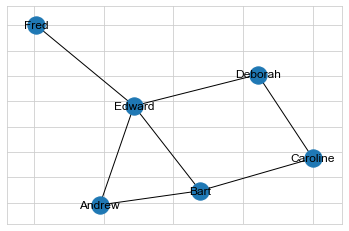

In [11]:
pos = nx.spring_layout(g_friends, seed=123)
nx.draw_networkx_nodes(g_friends, pos)
nx.draw_networkx_edges(g_friends, pos=pos)
nx.draw_networkx_labels(g_friends, pos=pos);

## Working with node-edge lists

If you are working with node-edge lists, it is likely that the most reliable way to get data into networkX is through looping through the data structure. Lets see how this might look, going back do our dataframe of book reviews, which already has this format.

In [13]:
df_docs.head(7)

,source,target,weight
0,0,1,0.306
1,0,2,0.352
2,0,3,0.401
3,0,4,0.859
4,0,5,0.566
5,0,6,0.304
6,0,7,0.143


first we use the ```nx.Graph()``` constructor to create an empty graph.

In [14]:
G_test = nx.Graph()

then we can use the graph method ```G_test.add_node()``` to add nodes. You can do this through looping: 

In [15]:
for node in df_docs.source:
    G_test.add_node(node)

Or you can use list comprehensions

In [16]:
G_test = nx.Graph()
[G_test.add_node(node) for node in df_docs.source];

Getting the edges in is tricky, as here you need to "zip" various lists into a "tuple".

In [17]:
for node, edge, weight in zip(df_docs.source, df_docs.target, df_docs.weight):
    G_test.add_edge(node, edge, weight=weight)

Here is the expected result

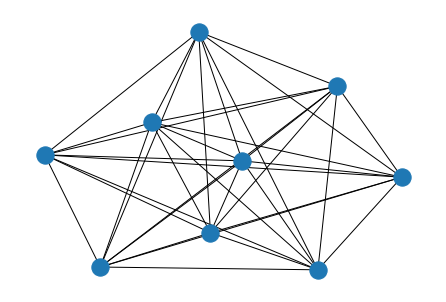

In [18]:
nx.draw(G_test)

# 2. Text Similarity Networks

One possible application of network analysis in law is to compare text and identify the texts that are most similar or more different, or which text cluster together. Here we will introduce a basic approach for doing this, using a text distance measure to create a network of text similarity. 

For this we will need to import that package textdistance 
```python 
import textdistance
```

In [1]:
import textdistance

We start with some Amazon reviews of the book "The Ordinary Virtues" by Michael Ignatieff, which you can see below. These were just copy-pasted from Amazon.

In [2]:
df_reviews = pd.read_csv("data/ignatieff_reviews.csv")

In [17]:
df_reviews

,Reviewer,Stars,Review
0,Tom,5,A really interesting perspective on the world'...
1,Merrie,5,This is a remarkable book with observations th...
2,Tatler,4,"Perceptive, well-written by qualified analyst...."
3,Nissim,5,The book is very important because it exposes ...
4,Regina,5,Very good
5,Nir,5,"great book, fascinating, lucidly-presented arg..."
6,David,4,This is a moving and humane reflection on mora...
7,Richard,1,The author sincerely believes that if we prole...
8,Tapas,3,It is a book about the modern globalized world...


The next thing is to use a measure of distance to compare every text to each other. The simplest measure of distance is jaccard similarity. Such measure simply counts the ratio (the faction) of the set of tokens (that is mostly words) that are found in both documents and divides it by the total set of tokens that is found in both documents. That is:

$ J(A,B) = \frac{\vert A \cap B \vert}{\vert A \cup B \vert} $

With code we can calculate jaccard distance for every pair (i,j) of reviews, store it in an array, and turn it into a 9x9 matrix. 


In [3]:
# initialize an empty list to store the results
sim = []
# compare every one of the reviews...
for i in df_reviews.Review:
# with every other of the reviews...
    for j in df_reviews.Review:
# using jaccard distance...
        result = textdistance.algorithms.jaccard(i,j)
# store the results in the list
        sim.append(result)
# finally turn the list into a matrix
simMatrix = np.array(sim).reshape(9,9)

For insight we can visualize the matrix as a heatmap. This heatmap has been designed so that the "hotter" the coolor is, the more there is a similarity between the two texts. Note that the diagonal of ones in red simply denotes that every document has also been compared to itself, and that every document is maximally similar to itself. We might prefer to change these 1s into 0s, because they are not really informative, but that would make the code more complex, so for our purposes we just leave it as it is.

<AxesSubplot:>

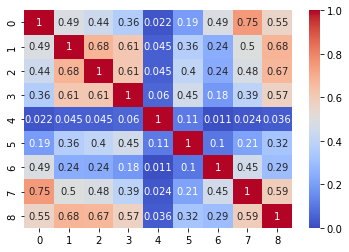

In [4]:
sns.heatmap(simMatrix, vmax=1, vmin=0, annot=True, cmap="coolwarm")

Note that by necessity in this matrix there are values for every combination of rows and columns. This signals that the resulting matrix will be fully connected. Also note that the diagonal is made of 1. This means that every doucument is maximally similar to itself. Note that the matrix is 9x9 and symmetrical (what is above the diagonal is a mirror image of what is below it). This will necessarily result from the comparision process, which will always produce a $ M \times M $ matrix of this sort. 

Such a matrix can be just directly fed into networkx to make a graph.


In [5]:
g_docs = nx.from_numpy_matrix(simMatrix)


The result is different than in the main file, because we have allowed every node to have a link with itself.

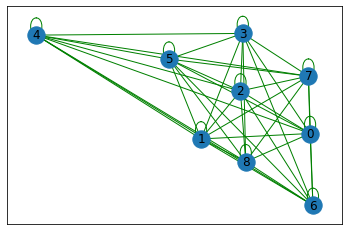

In [9]:
pos = nx.spring_layout(g_docs, seed=123)
nx.draw_networkx_nodes(g_docs, pos)
lowweight = [e for e in g_docs.edges if g_docs.edges[e]['weight'] < 0.3]
highweight = [e for e in g_docs.edges if g_docs.edges[e]['weight'] > 0.3]
nx.draw_networkx_edges(g_docs, pos = pos, edge_color="green")
# nx.draw_networkx_edges(g_docs, edgelist=highweight, pos=pos, edge_color='green')
# nx.draw_networkx_edges(g_docs, edgelist=lowweight, alpha=0.4, pos=pos, edge_color='red')
nx.draw_networkx_labels(g_docs, pos=pos);

Having such a network, one can venture to find which are the most central reviews, the most prototypical ones using measures that are covered in the main text:

In [16]:
close = nx.closeness_centrality(g_docs, distance="weight")
eig = nx.eigenvector_centrality(g_docs, weight="weight")
pd.DataFrame({"Reviewer":df_reviews.Reviewer, "closeness": list(dict(close).values()), "eig": list(dict(eig).values())})

,Reviewer,closeness,eig
0,Tom,15.777715,0.364633
1,Merrie,12.057838,0.399003
2,Tatler,12.057838,0.394062
3,Nissim,10.367095,0.360242
4,Regina,22.816745,0.036768
5,Nir,7.345767,0.242680
6,David,19.533768,0.233505
7,Richard,15.450462,0.374526
8,Tapas,13.319577,0.409561


Jaccard similarity is possibly the most basic measure of text dsitance, but many others exist, and depending on the measure used it may be wise to pre-process the text before making comparisons, for example removing stopwords. All of this would be beyond the scope of this presentation.